https://github.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/blob/main/HOTSAP_SARIMA.ipynb

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import weibull_min
from itertools import product
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv(folder_path, sep='\t')


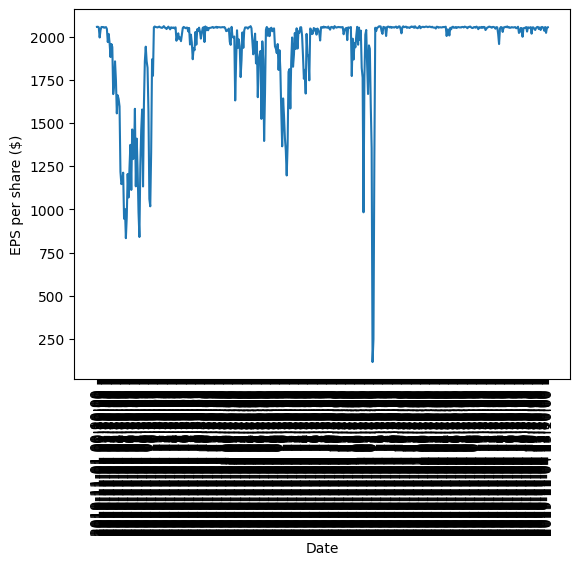

In [8]:
plt.plot(df['DATE'][:500], df['ActivePower'][:500])
plt.title('')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

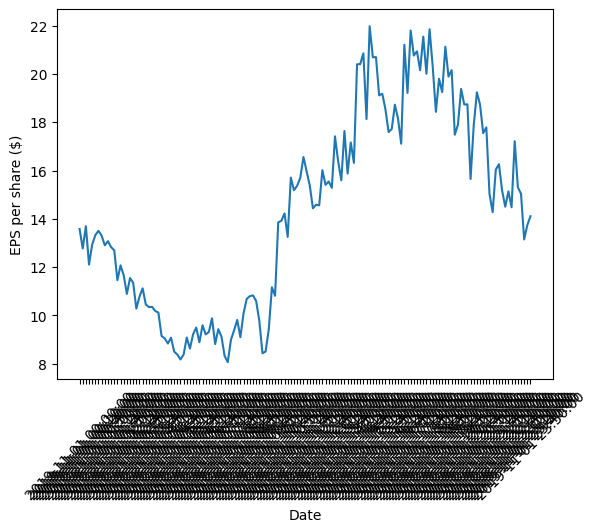

In [14]:
plt.plot(df['DATE'][:144], df['WindSpeed'][:144])
plt.title('')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.drop(['WF', 'WT', 'Index','DATE'], axis=1, inplace=True)
df=df[:2000]
df

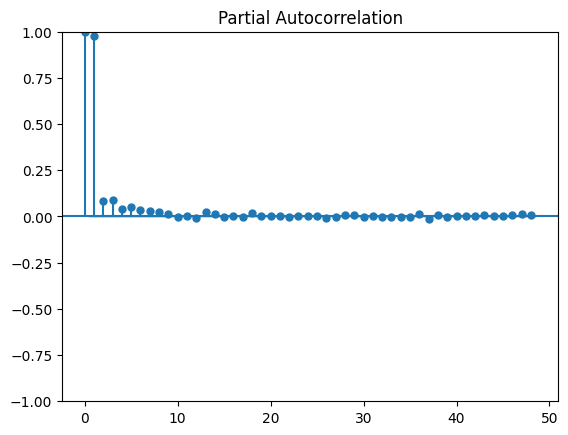

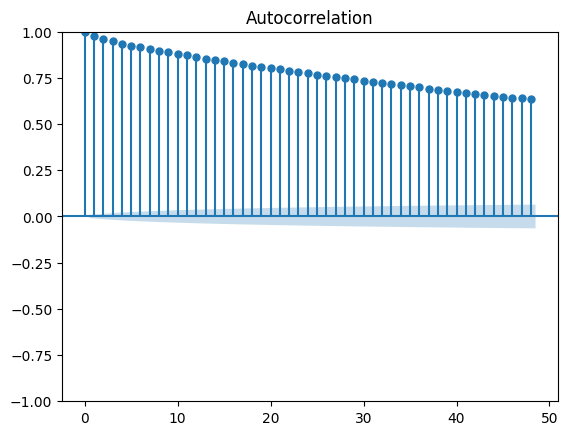

In [15]:
plot_pacf(df['ActivePower']);
plot_acf(df['ActivePower']);

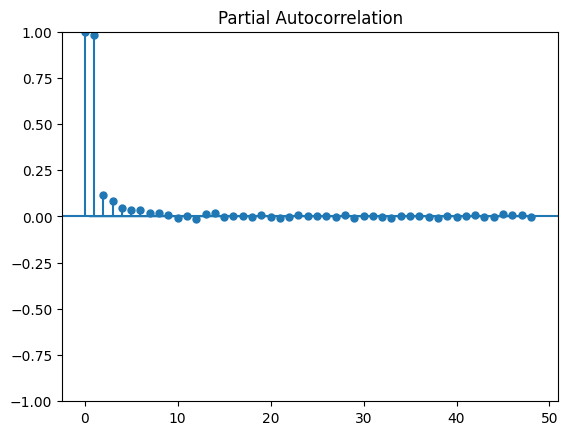

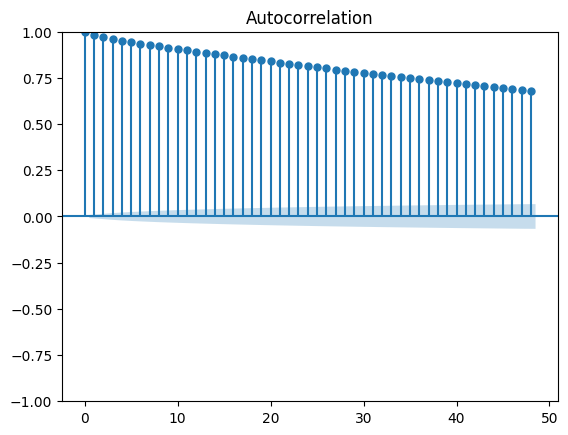

In [16]:
plot_pacf(df['WindSpeed']);
plot_acf(df['WindSpeed']);

# Tuning those parameters

In [19]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 6

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0)]


In [7]:
result_df2 = optimize_SARIMA(df["WindSpeed"], parameters_list, 1, 1, 6)
result_df2

  0%|          | 0/256 [00:00<?, ?it/s]

(p,q)x(P,Q)          AIC
0    (0, 2, 0, 1)  6298.295216
1    (0, 3, 0, 1)  6300.132846
2    (1, 2, 0, 1)  6300.141136
3    (0, 2, 1, 1)  6300.221853
4    (0, 2, 0, 2)  6300.222171
..            ...          ...
251  (3, 1, 0, 0)  7644.747707
252  (2, 0, 0, 0)  7653.557339
253  (0, 1, 0, 0)  7697.233135
254  (1, 0, 0, 0)  7747.219721
255  (0, 0, 0, 0)  7825.041314

[256 rows x 2 columns]

In [7]:
best_model2 = SARIMAX(df["WindSpeed"], order=(0,1,2), seasonal_order=(0,1,1,6), simple_differencing=False)
res2 = best_model2.fit(disp=False)
print(res2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           WindSpeed   No. Observations:                 2000
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 6)   Log Likelihood               -3145.148
Date:                             Fri, 14 Jul 2023   AIC                           6298.295
Time:                                     10:48:26   BIC                           6320.685
Sample:                                          0   HQIC                          6306.518
                                            - 2000                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2893      0.018    -16.121      0.000      -0.324      -0.254
ma.L2         -0.1719      

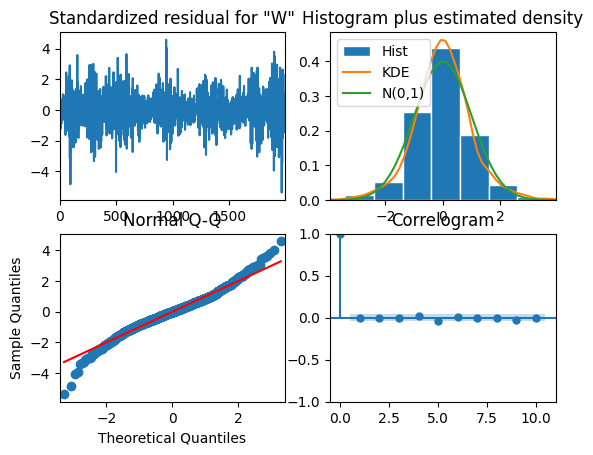

In [9]:
res2.plot_diagnostics();

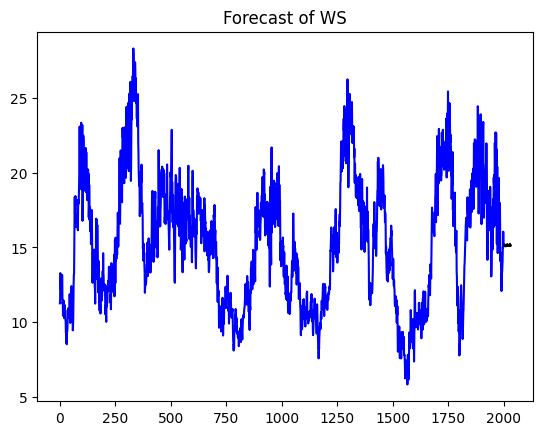

In [23]:
n_forecast = 32
predict2 = res2.get_prediction(end=best_model2.nobs + n_forecast)
idx = np.arange(len(predict2.predicted_mean))

fig, ax = plt.subplots()
ax.plot(df["WindSpeed"], 'blue')
ax.plot(idx[-n_forecast:], predict2.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of WS')
plt.show()

In [25]:
df['WS_predicted'] = predict2.predicted_mean
df.head(15)

ActivePower  WindSpeed  WS_predicted
0    1800.87500   11.26842      0.000000
1    1678.97500   11.52703     11.268416
2    2012.77500   13.28718     11.527027
3    1932.05000   12.21351     13.287179
4    2030.02500   12.44211     12.213511
5    2019.37500   12.79737     12.442112
6    1851.22500   12.02778     18.431580
7    1949.41026   12.36750     12.286398
8    1918.53846   12.03684     14.110201
9    1914.10000   11.54500     11.490705
10   2026.80000   13.16316     12.094007
11   1994.25000   12.33611     13.183051
12   1754.42500   11.25278     11.448460
13   1848.05128   11.36944     11.703335
14   1561.62500   10.43750     12.199724

In [26]:
mse = mean_squared_error(df['WindSpeed'], df['WS_predicted'])
print(f'MSE: {mse}')

MSE: 1.453437553865836


In [28]:
mape = np.mean(np.abs(df['WindSpeed'] - df['WS_predicted']) / np.abs(df['WindSpeed'] ))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: 5.75%


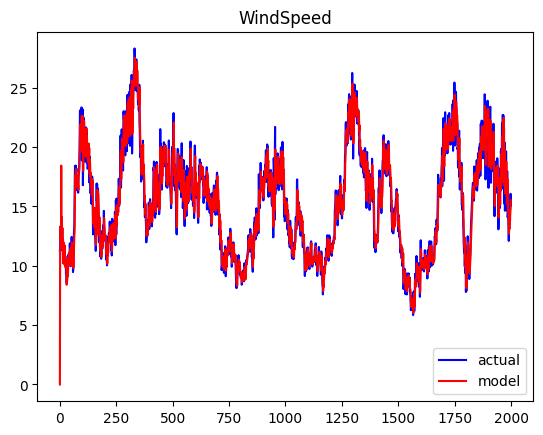

In [30]:
plt.plot(df['WindSpeed'], color='blue', label='actual')
plt.plot(df['WS_predicted'], color='red', label='model')
plt.legend(loc='best')
plt.title('WindSpeed')
plt.show()

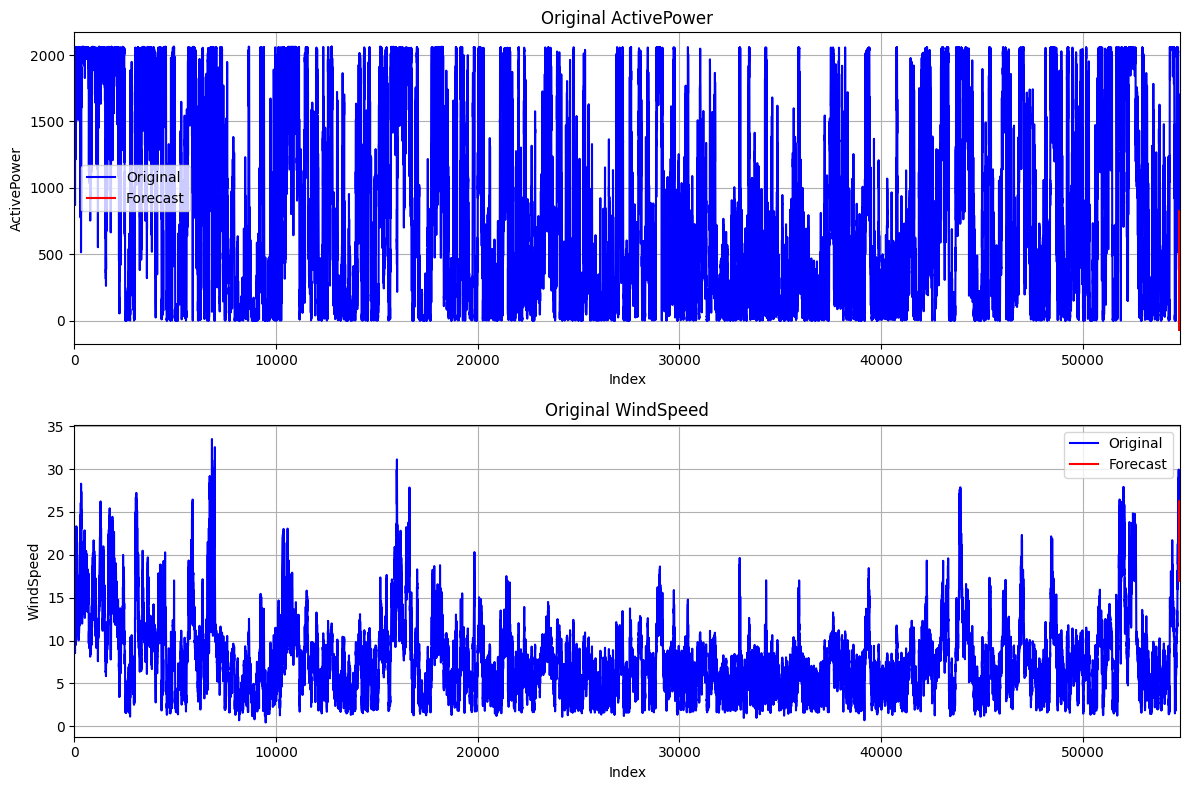

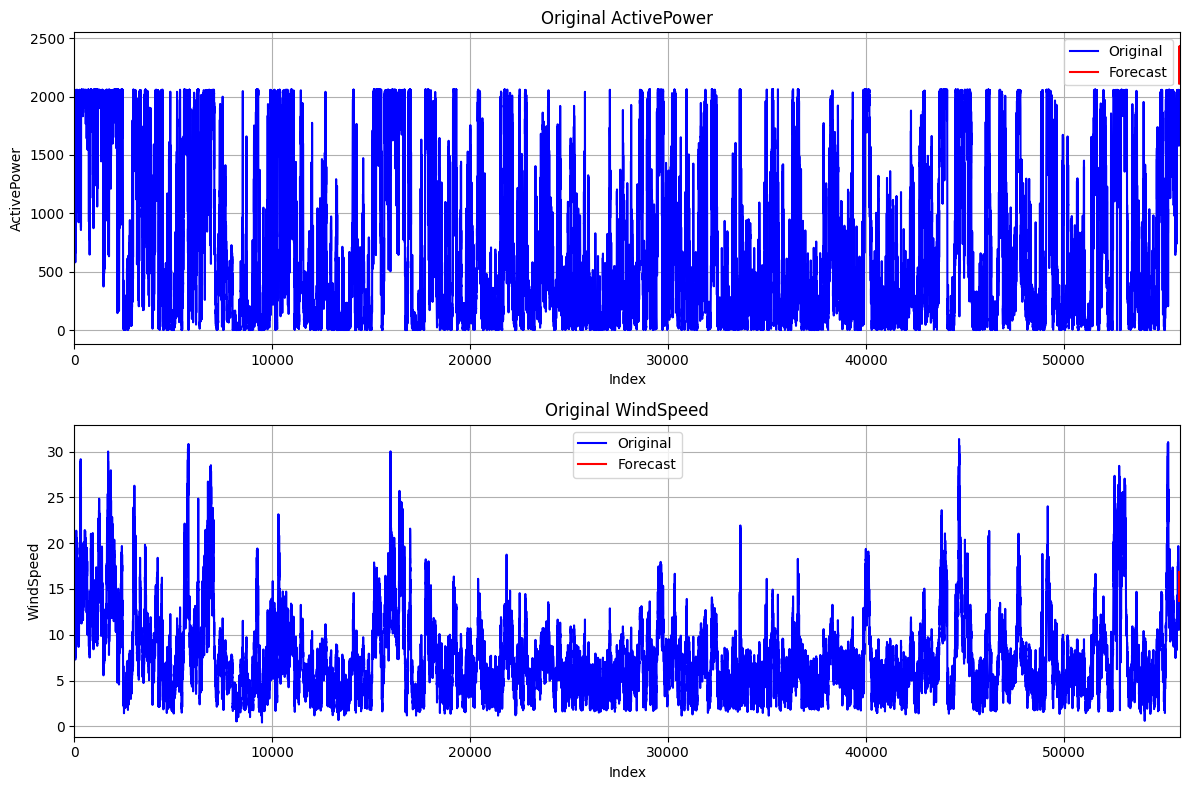

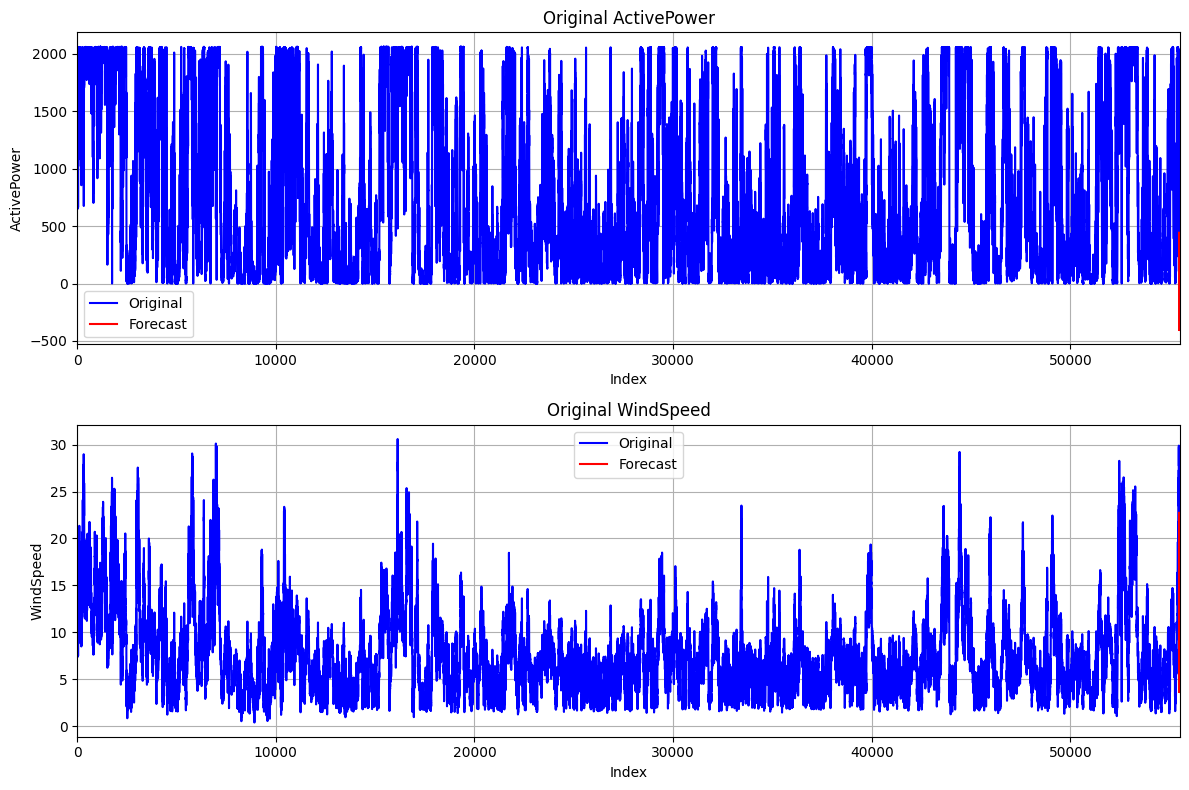

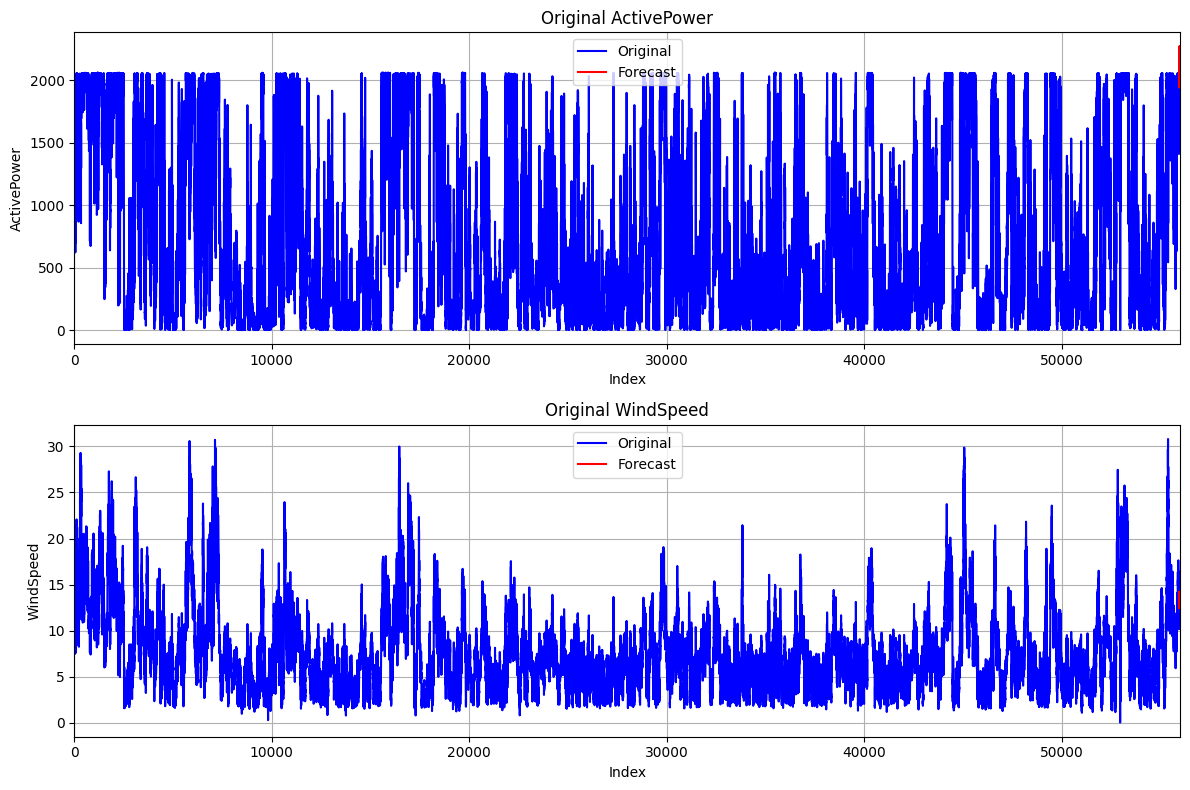

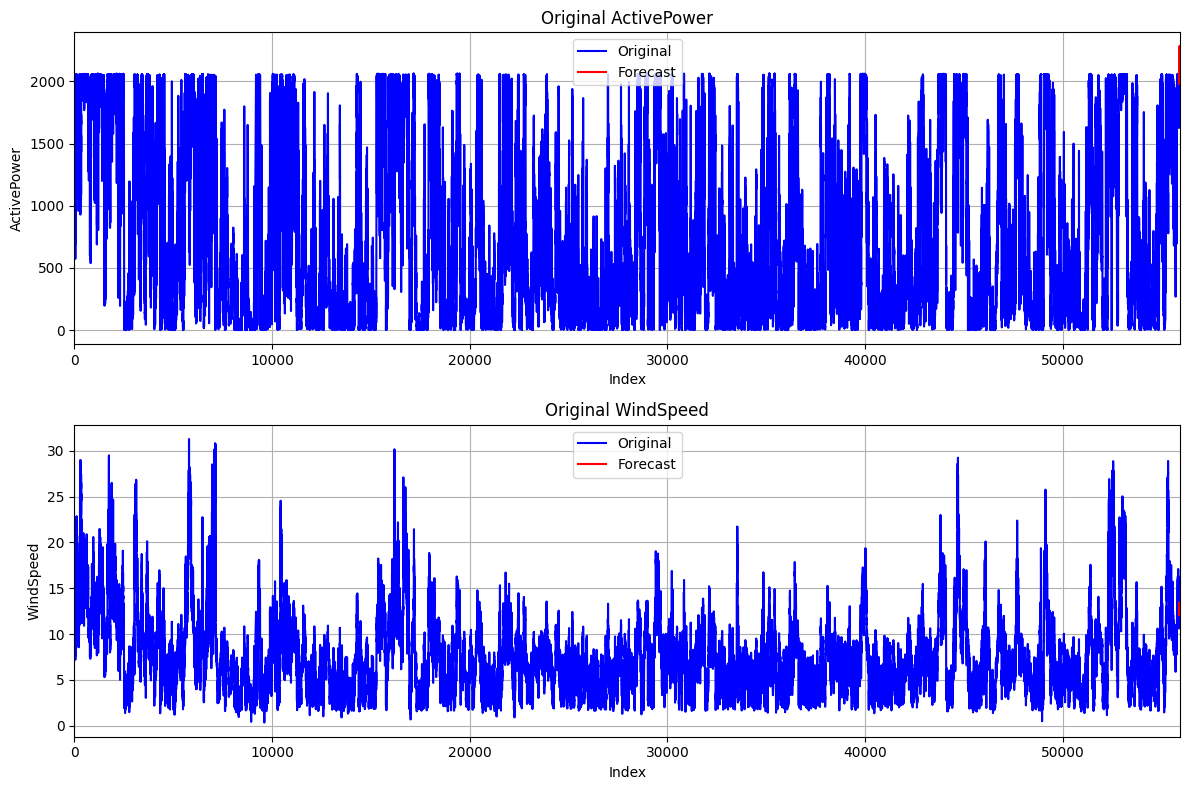

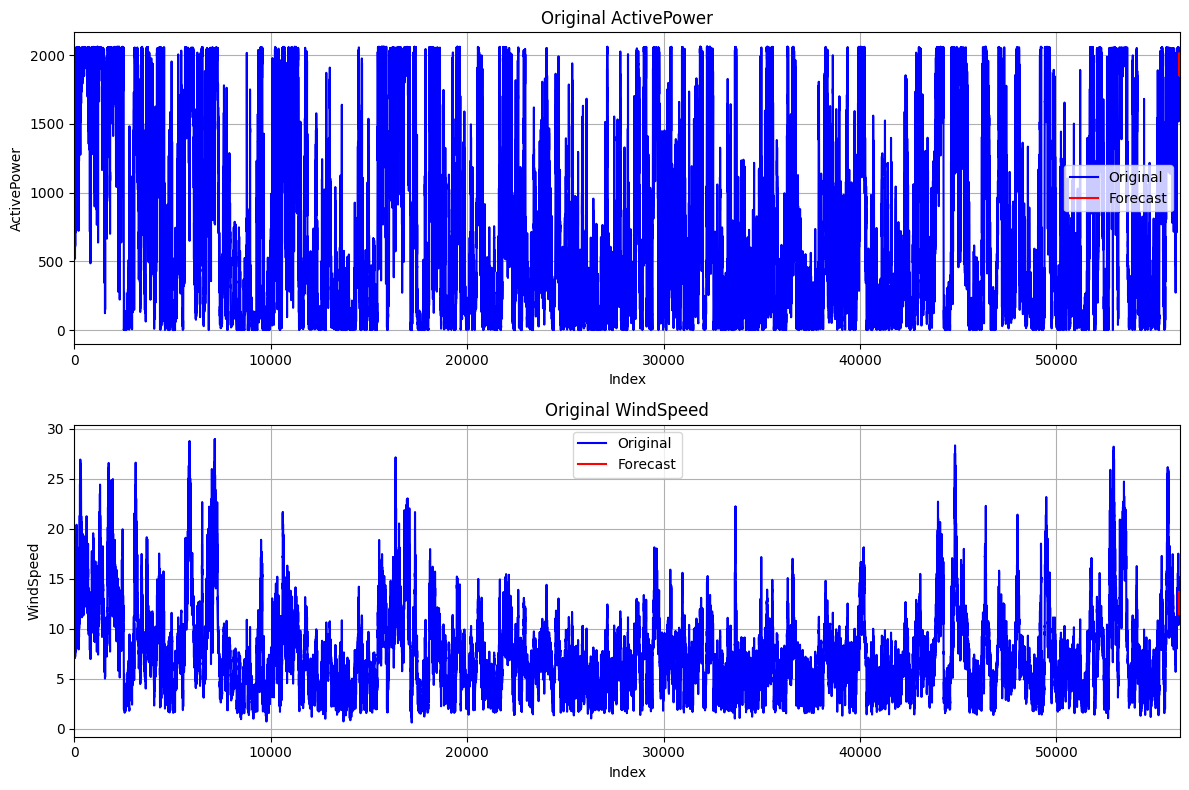

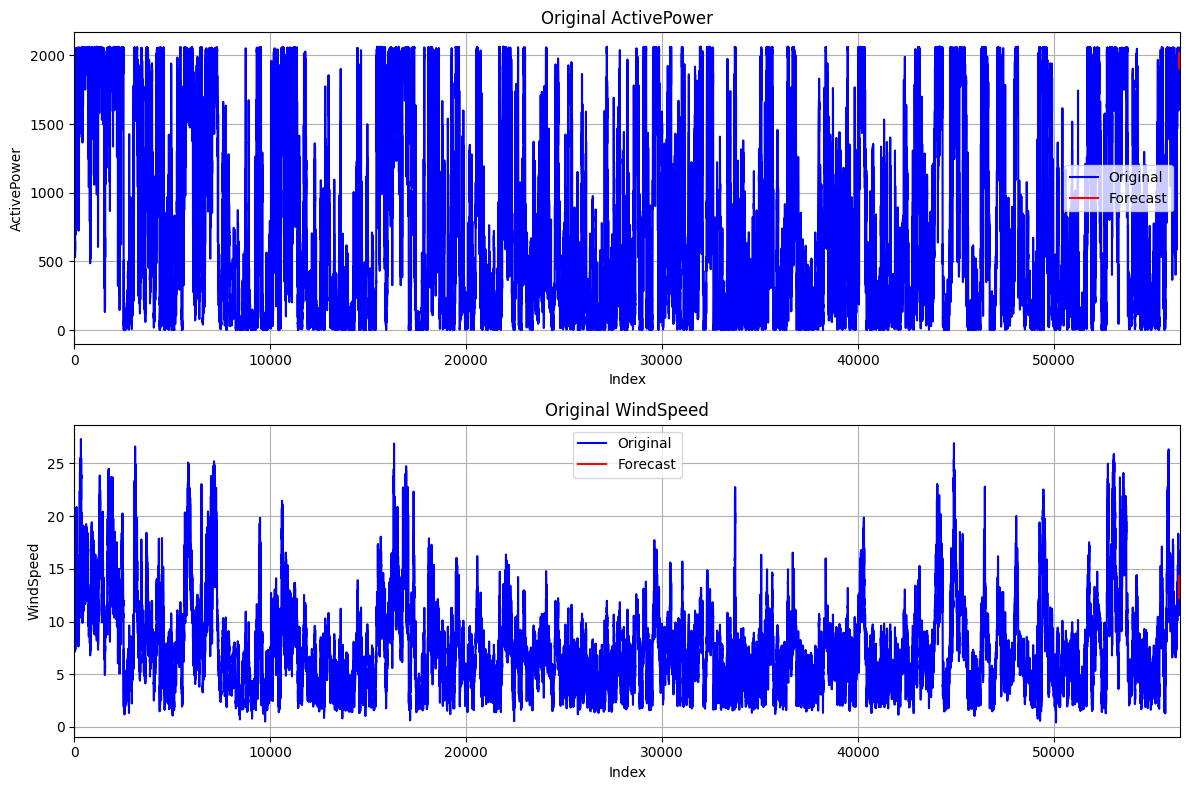

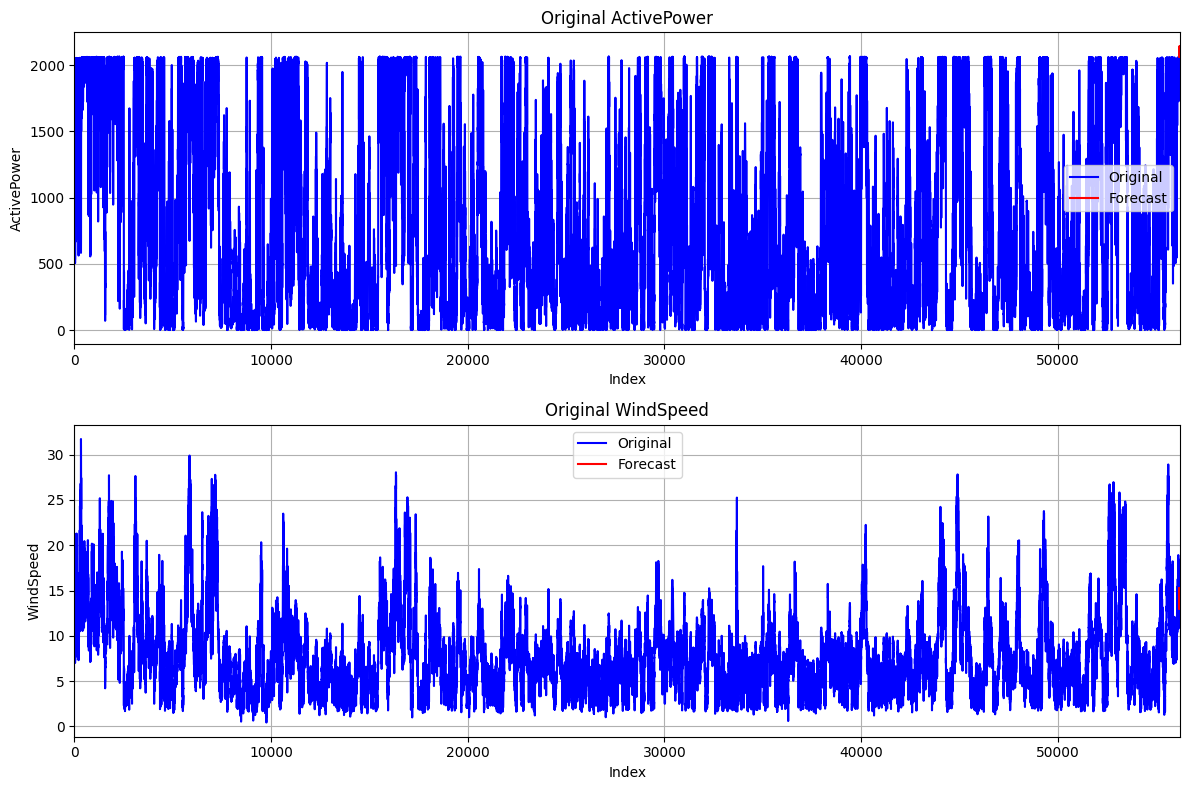

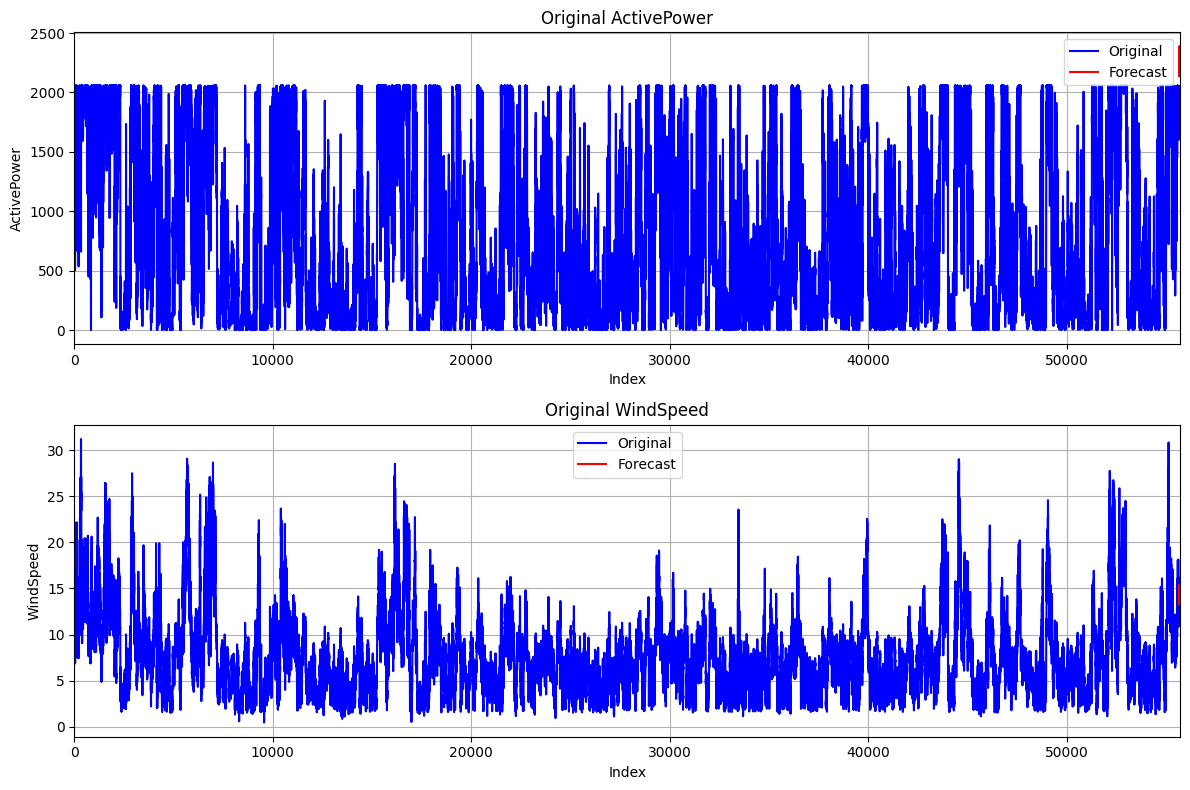

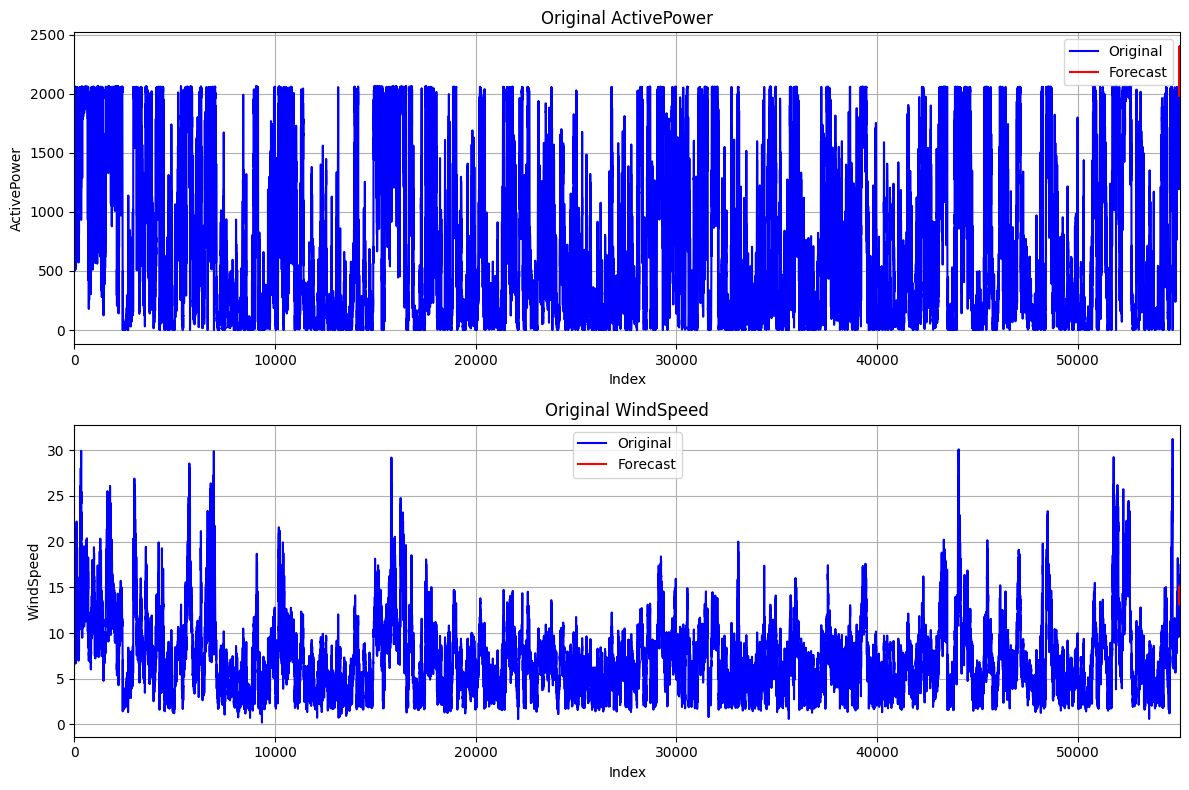

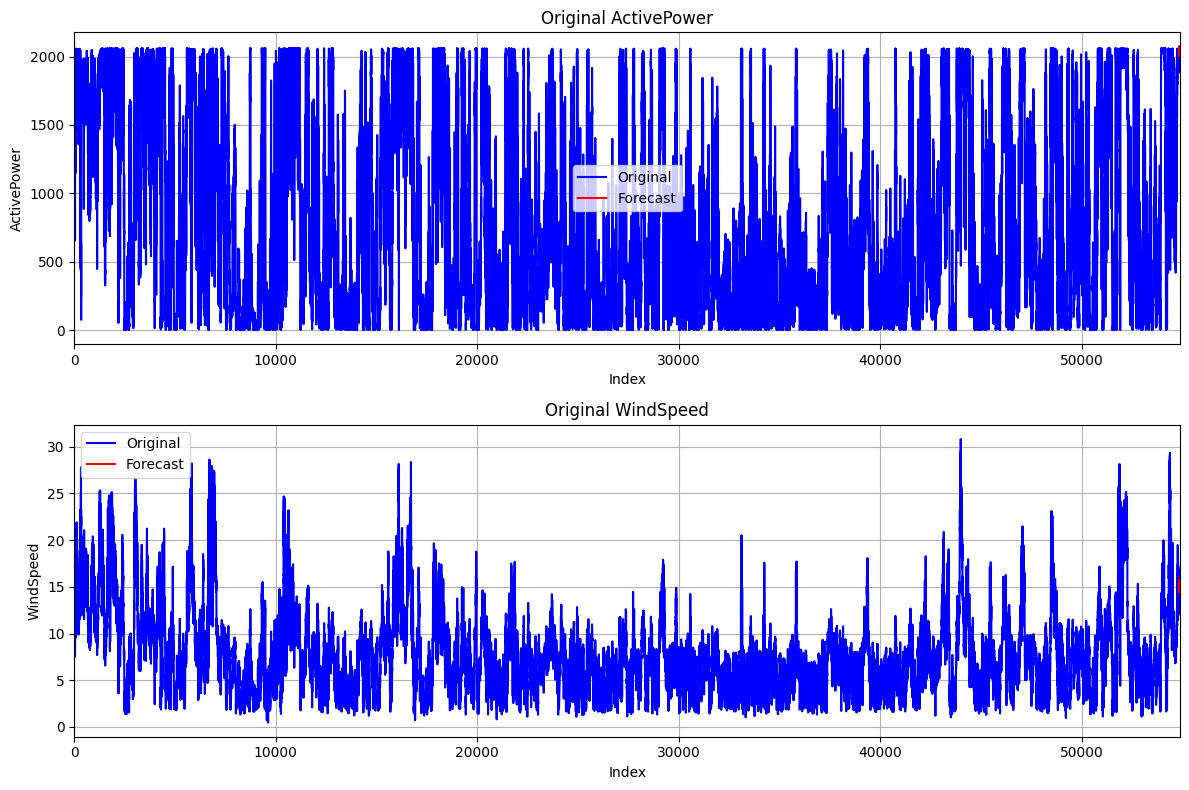

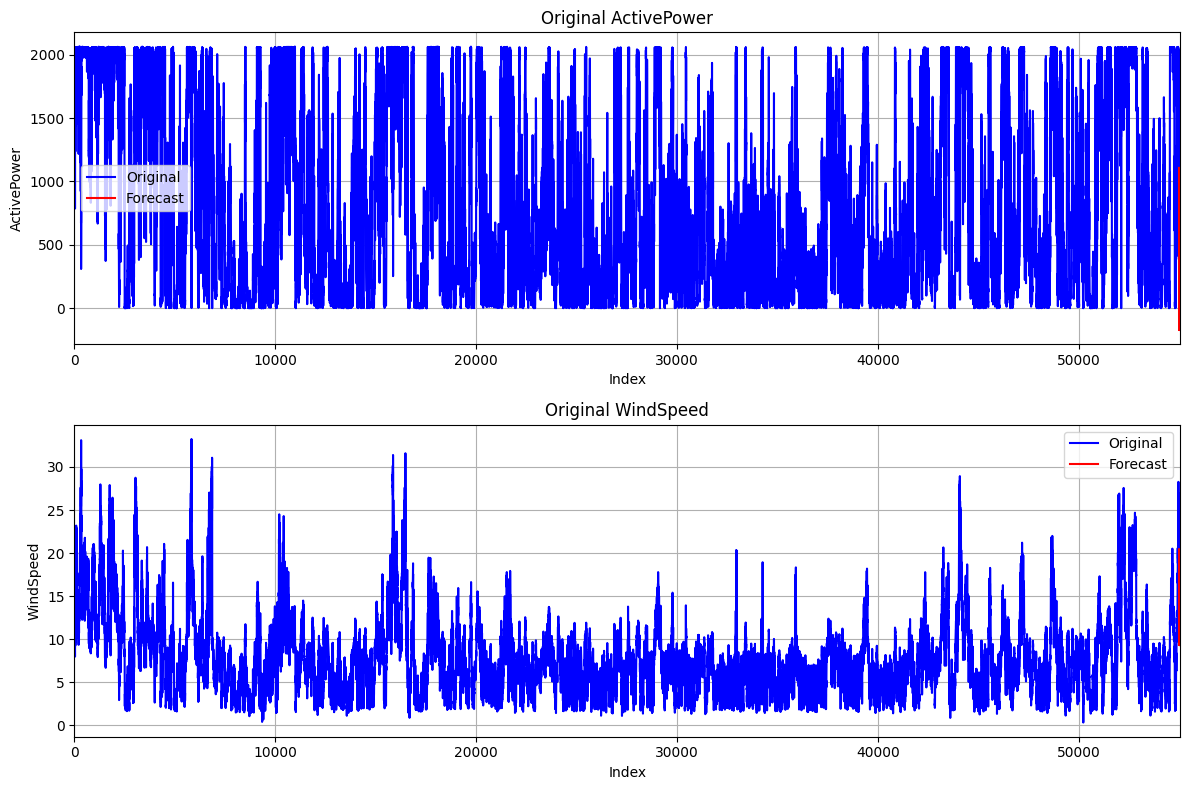

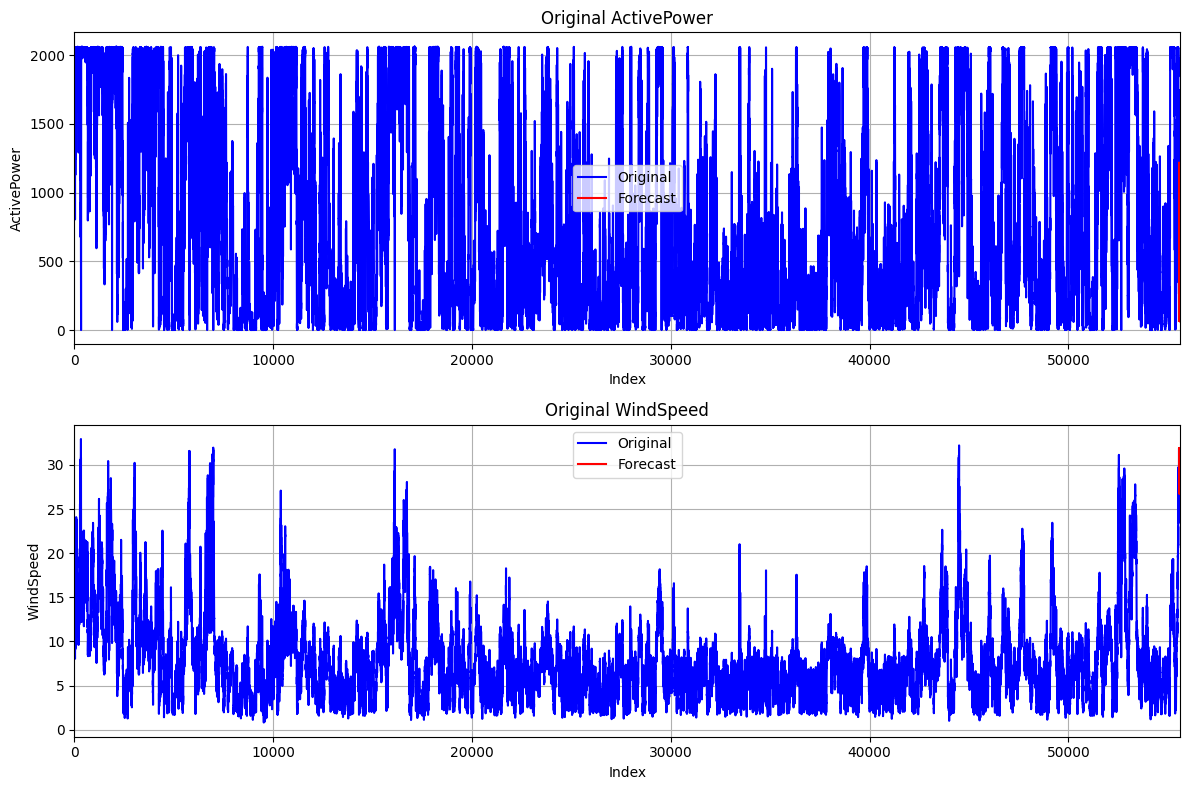

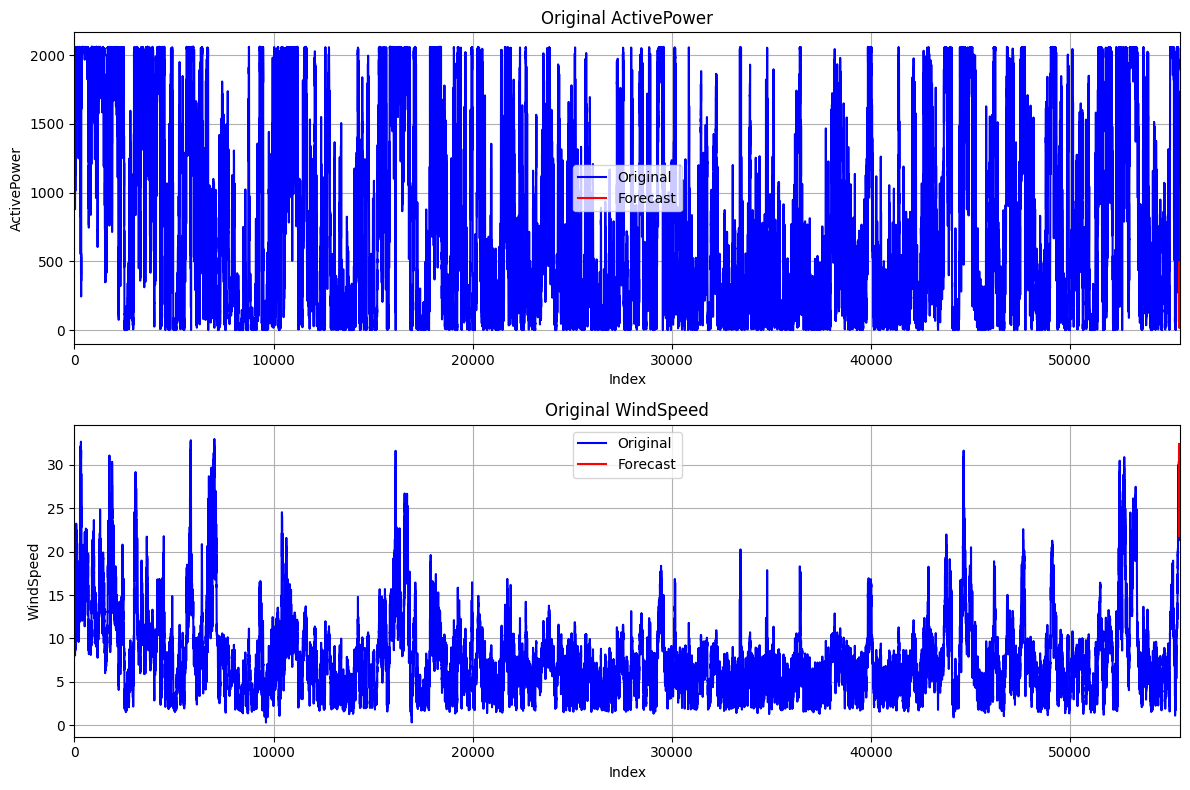

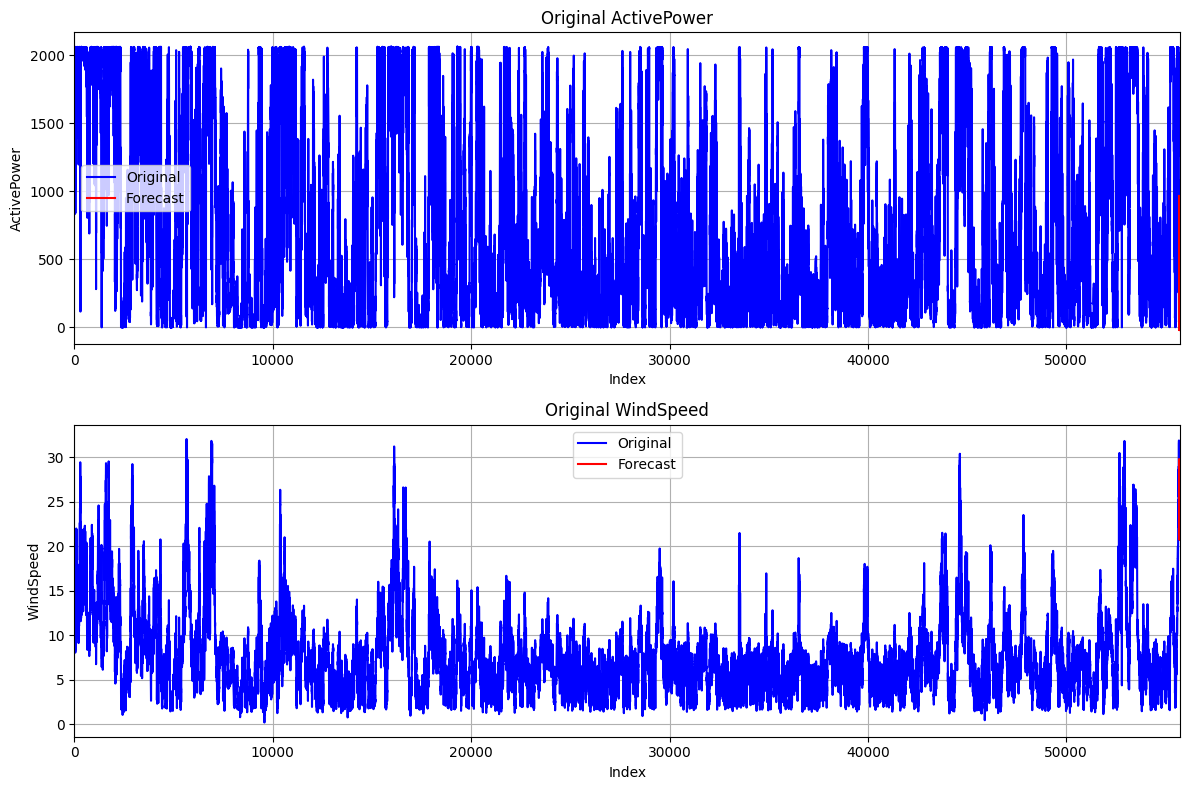

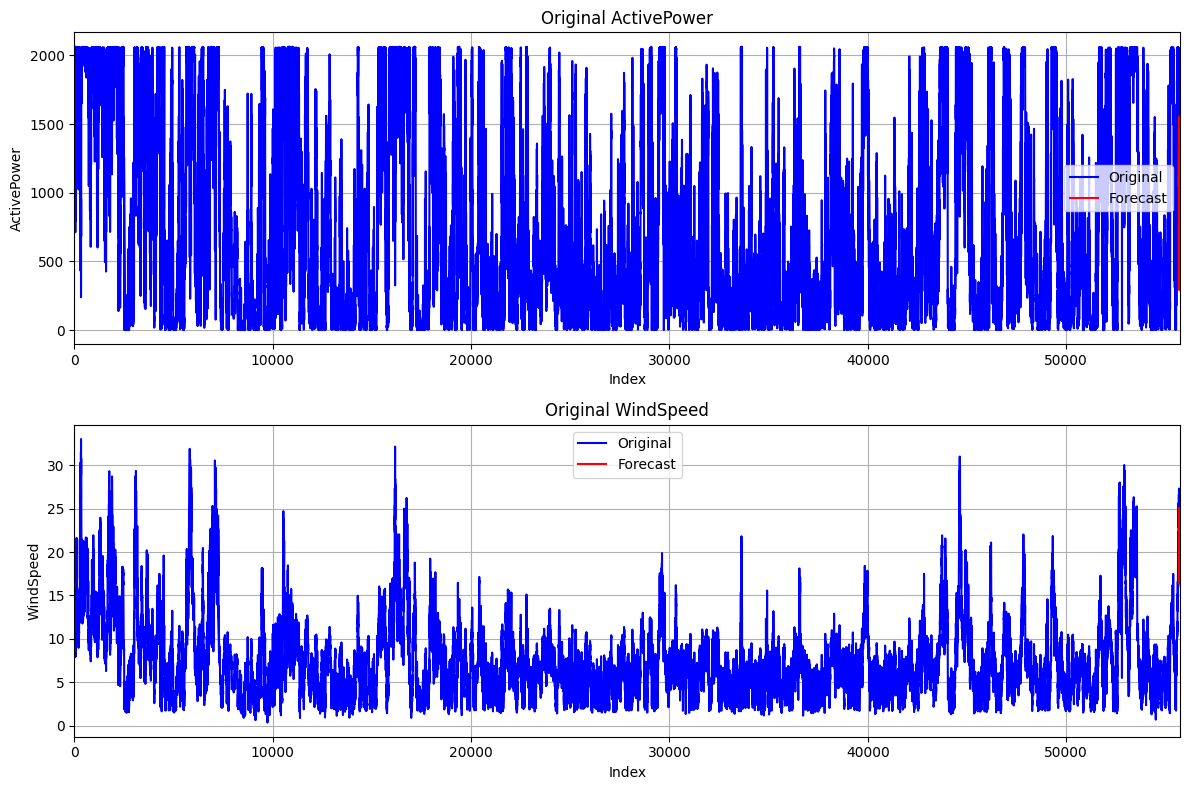

In [ ]:


def apply_sarima_forecast(folder_path, num_data_points, num_predictions, seasonality):
    # Iterate over files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            # Load the file
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep='\t')

            # Create a figure with two subplots for the original data and forecasts
            fig, axs = plt.subplots(2, 1, figsize=(12, 8))

            # Original data plot: ActivePower
            axs[0].plot(df['ActivePower'], color='blue', label='Original')
            axs[0].set_xlabel('Index')
            axs[0].set_ylabel('ActivePower')
            axs[0].set_title('Original ActivePower')
            axs[0].legend()
            axs[0].grid(True)

            # Original data plot: WindSpeed
            axs[1].plot(df['WindSpeed'], color='blue', label='Original')
            axs[1].set_xlabel('Index')
            axs[1].set_ylabel('WindSpeed')
            axs[1].set_title('Original WindSpeed')
            axs[1].legend()
            axs[1].grid(True)

            # Perform SARIMA forecasting
            active_power_model = sm.tsa.statespace.SARIMAX(df['ActivePower'], order=(2, 1, 3), seasonal_order=(0, 1, 2, seasonality))
            active_power_results = active_power_model.fit()
            active_power_forecast = active_power_results.get_forecast(steps=num_predictions)

            wind_speed_model = sm.tsa.statespace.SARIMAX(df['WindSpeed'], order=(1, 0, 0), seasonal_order=(0, 1, 0, seasonality))
            wind_speed_results = wind_speed_model.fit()
            wind_speed_forecast = wind_speed_results.get_forecast(steps=num_predictions)

            # Plot the forecasts
            axs[0].plot(range(len(df), len(df) + num_predictions), active_power_forecast.predicted_mean, color='red', label='Forecast')
            axs[0].set_xlim(0, len(df) + num_predictions)
            axs[0].legend()

            axs[1].plot(range(len(df), len(df) + num_predictions), wind_speed_forecast.predicted_mean, color='red', label='Forecast')
            axs[1].set_xlim(0, len(df) + num_predictions)
            axs[1].legend()

            plt.tight_layout()
            plt.show()

# Example usage
folder_path = ""
num_data_points = 144  # Number of data points per day
num_predictions = 48  # Number of predictions to be made
seasonality = 6  # Seasonality parameter for SARIMA model

apply_sarima_forecast(folder_path, num_data_points, num_predictions, seasonality)


Original File: arganil_turbine_1.txt


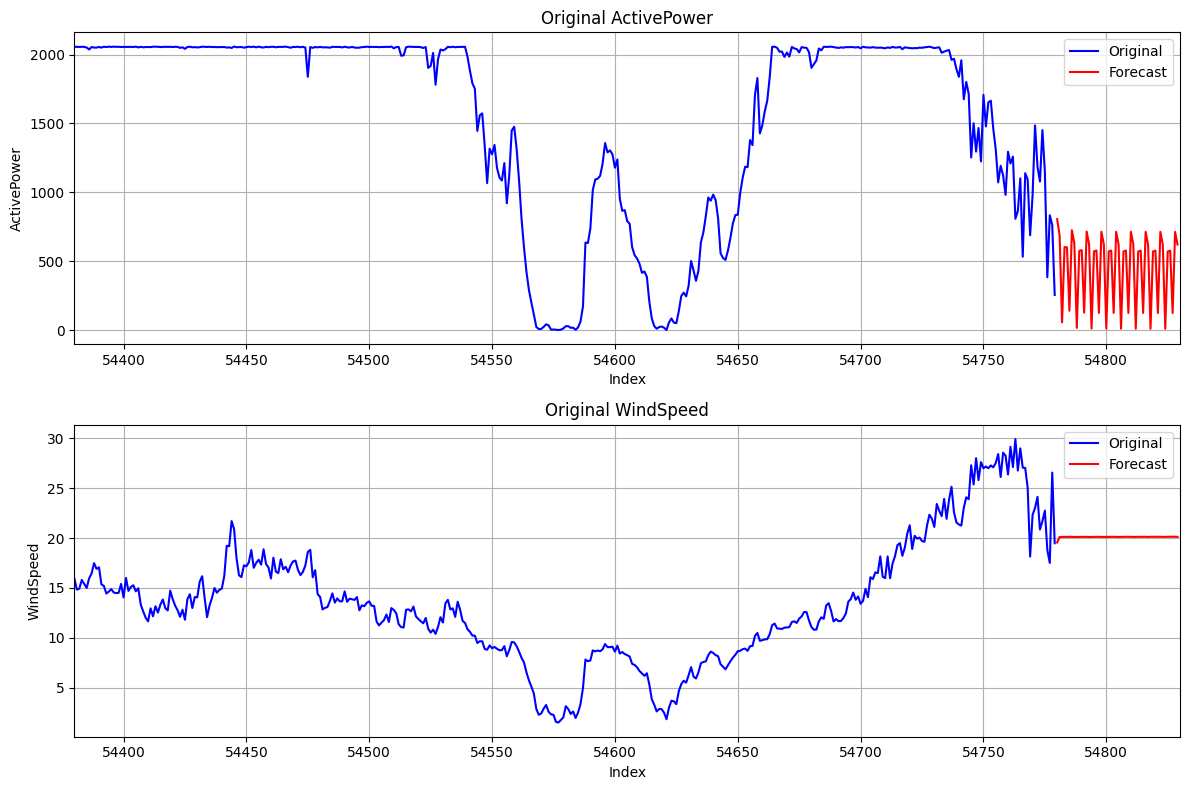

MSR for ActivePower: 1180194.3064
MAPE for ActivePower: 0.6701
MSR for WindSpeed: 30.1117
MAPE for WindSpeed: 0.1856
Original File: arganil_turbine_10.txt


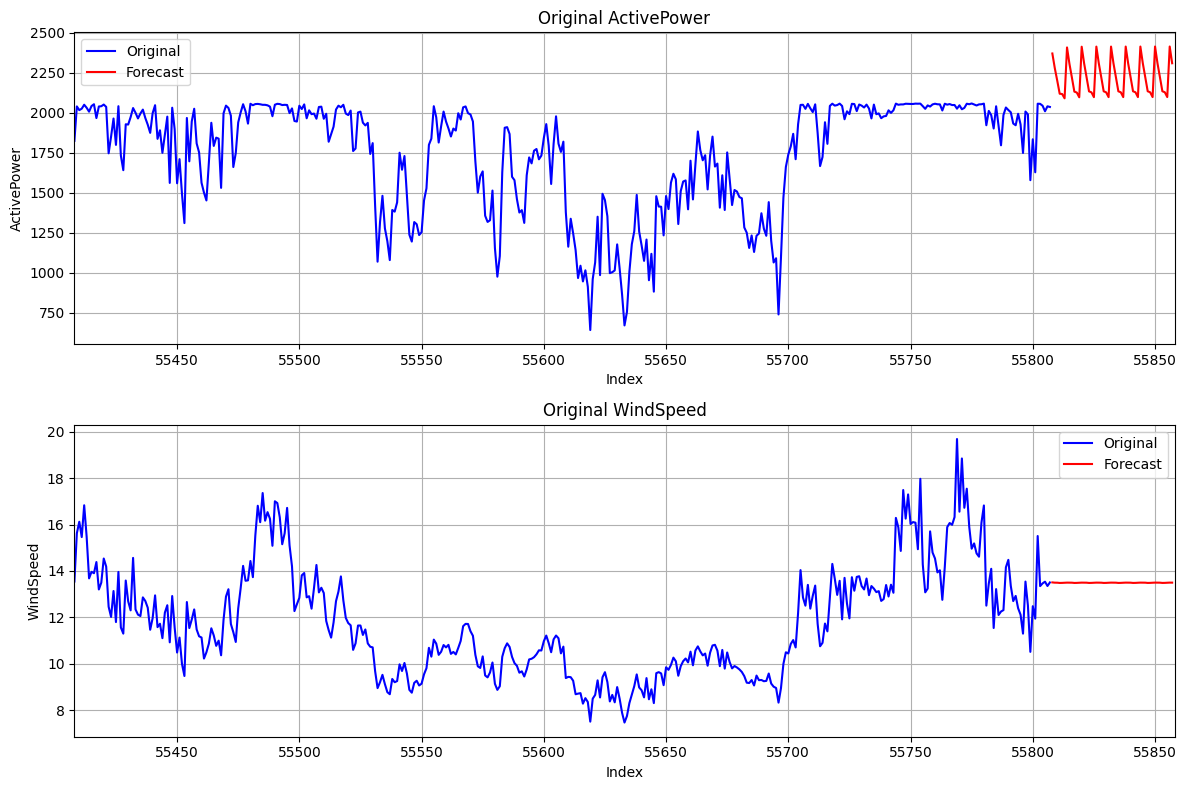

MSR for ActivePower: 75435.1308
MAPE for ActivePower: 0.1190
MSR for WindSpeed: 4.1544
MAPE for WindSpeed: 0.1037
Original File: arganil_turbine_11.txt


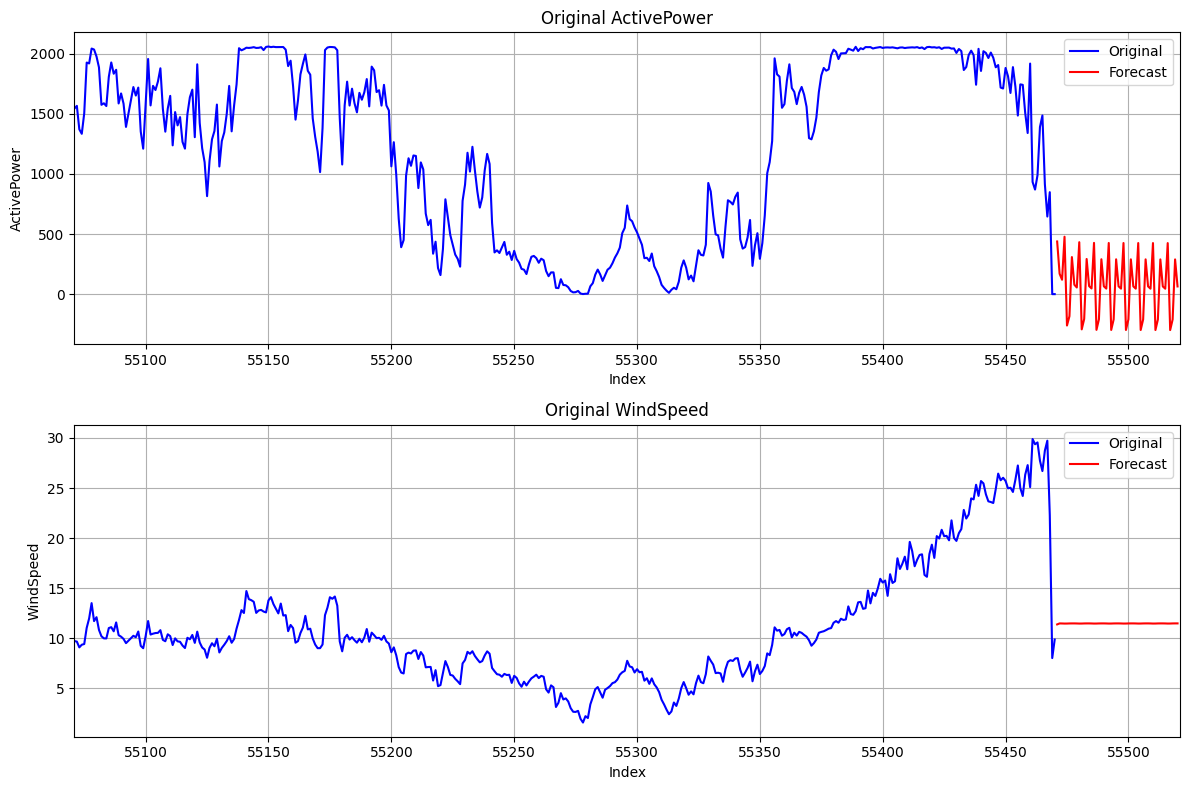

MSR for ActivePower: 2889704.3908
MAPE for ActivePower: 31767282242207080.0000
MSR for WindSpeed: 164.0797
MAPE for WindSpeed: 0.5095
Original File: arganil_turbine_12.txt


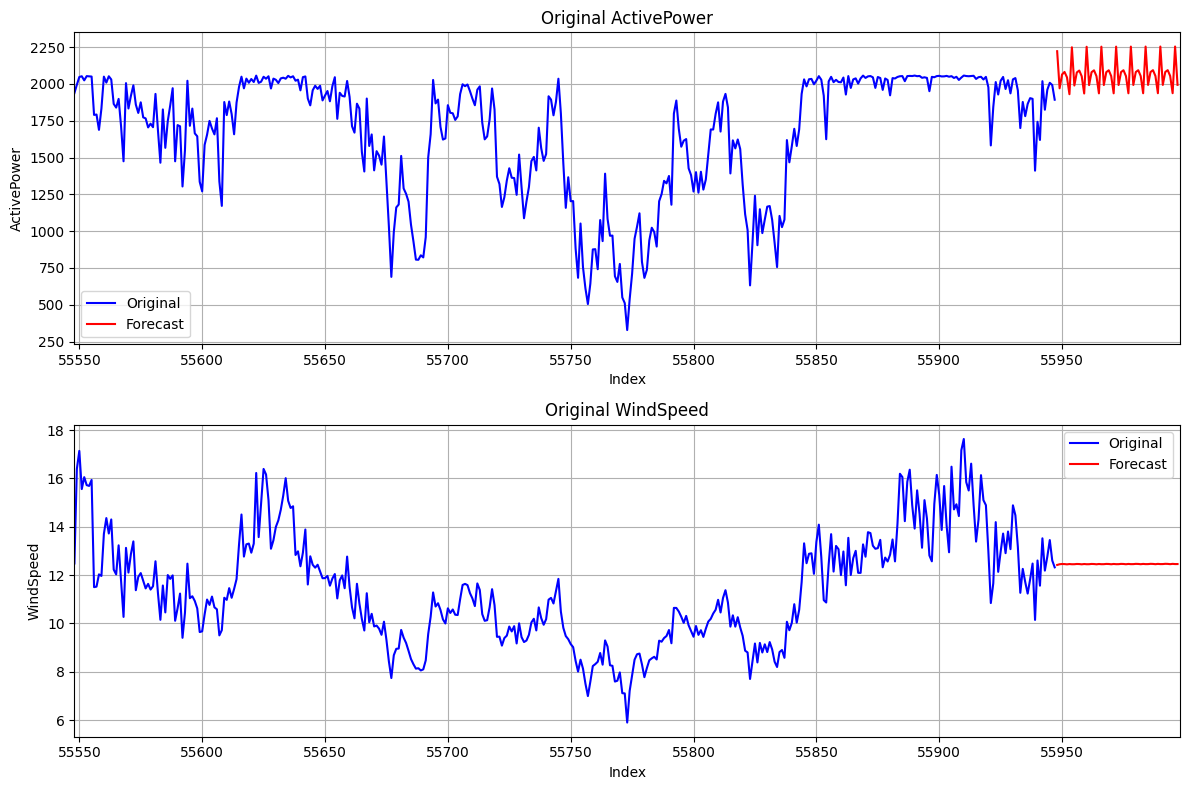

MSR for ActivePower: 36266.1541
MAPE for ActivePower: 0.0758
MSR for WindSpeed: 4.6471
MAPE for WindSpeed: 0.1174
Original File: arganil_turbine_13.txt


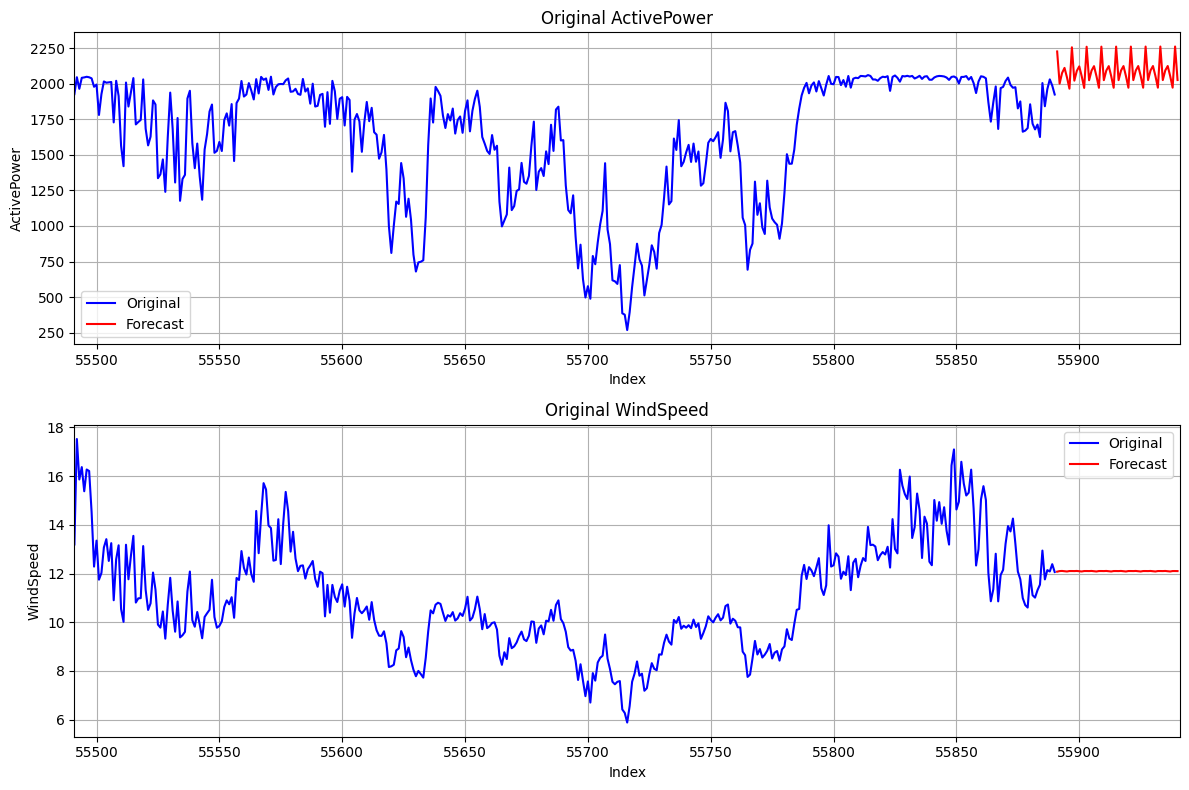

MSR for ActivePower: 48098.2013
MAPE for ActivePower: 0.0903
MSR for WindSpeed: 4.5652
MAPE for WindSpeed: 0.1163
Original File: arganil_turbine_14.txt


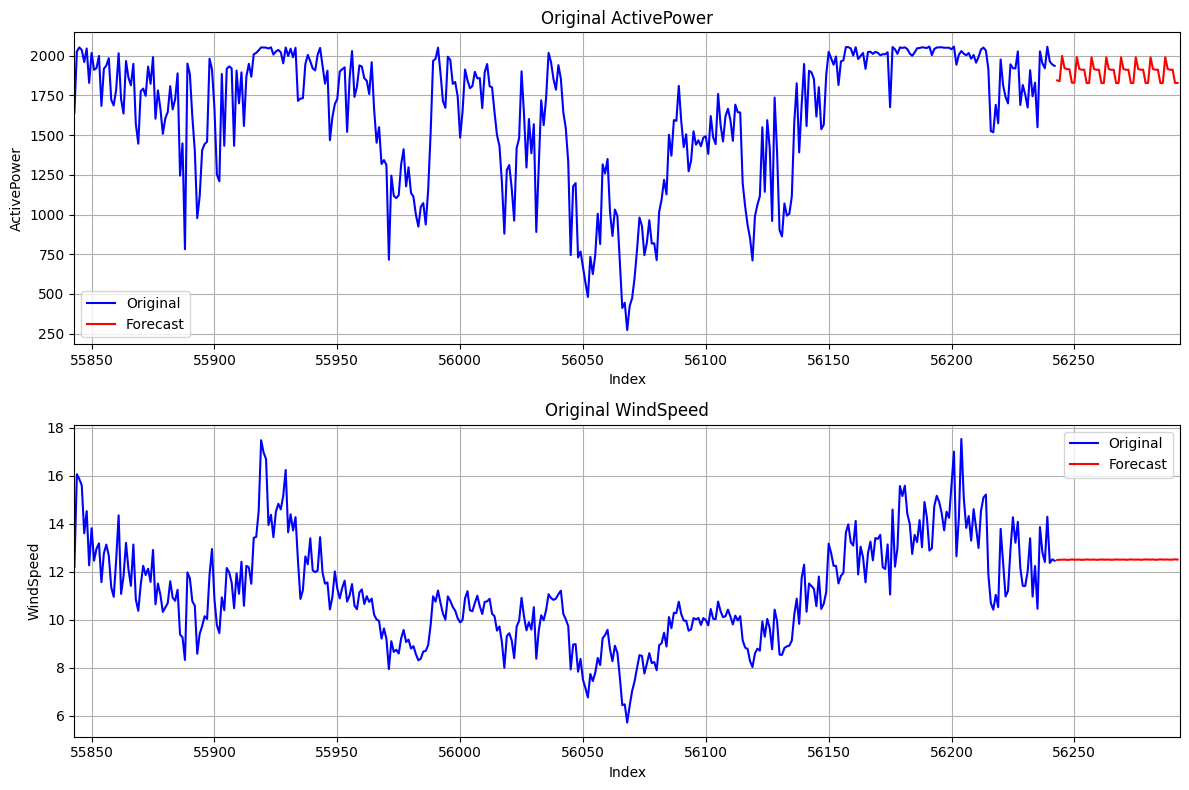

MSR for ActivePower: 26313.3857
MAPE for ActivePower: 0.0719
MSR for WindSpeed: 3.3322
MAPE for WindSpeed: 0.1091
Original File: arganil_turbine_15.txt


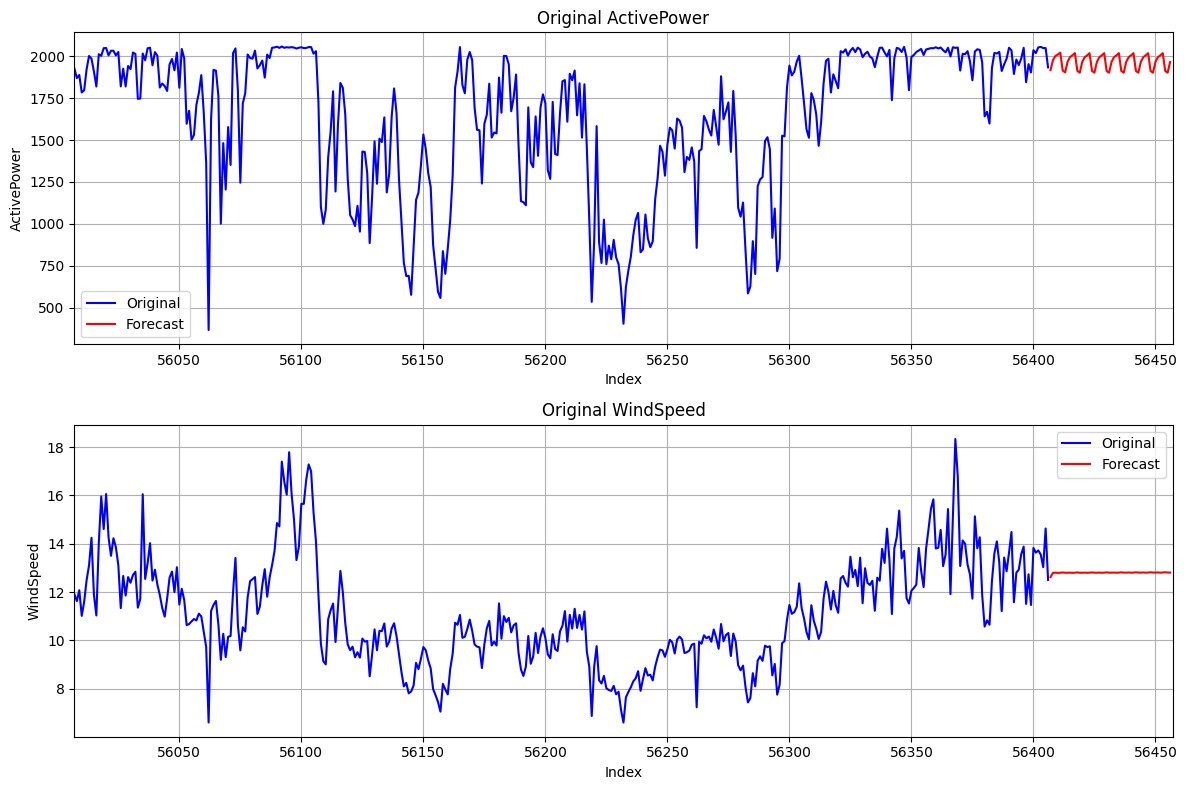

MSR for ActivePower: 10099.5737
MAPE for ActivePower: 0.0364
MSR for WindSpeed: 2.7106
MAPE for WindSpeed: 0.0920
Original File: arganil_turbine_16.txt


MSR for ActivePower: 12354.9323
MAPE for ActivePower: 0.0428
MSR for WindSpeed: 2.6481
MAPE for WindSpeed: 0.0782
Original File: arganil_turbine_17.txt


MSR for ActivePower: 90053.2677
MAPE for ActivePower: 0.1373
MSR for WindSpeed: 2.3861
MAPE for WindSpeed: 0.0847
Original File: arganil_turbine_18.txt


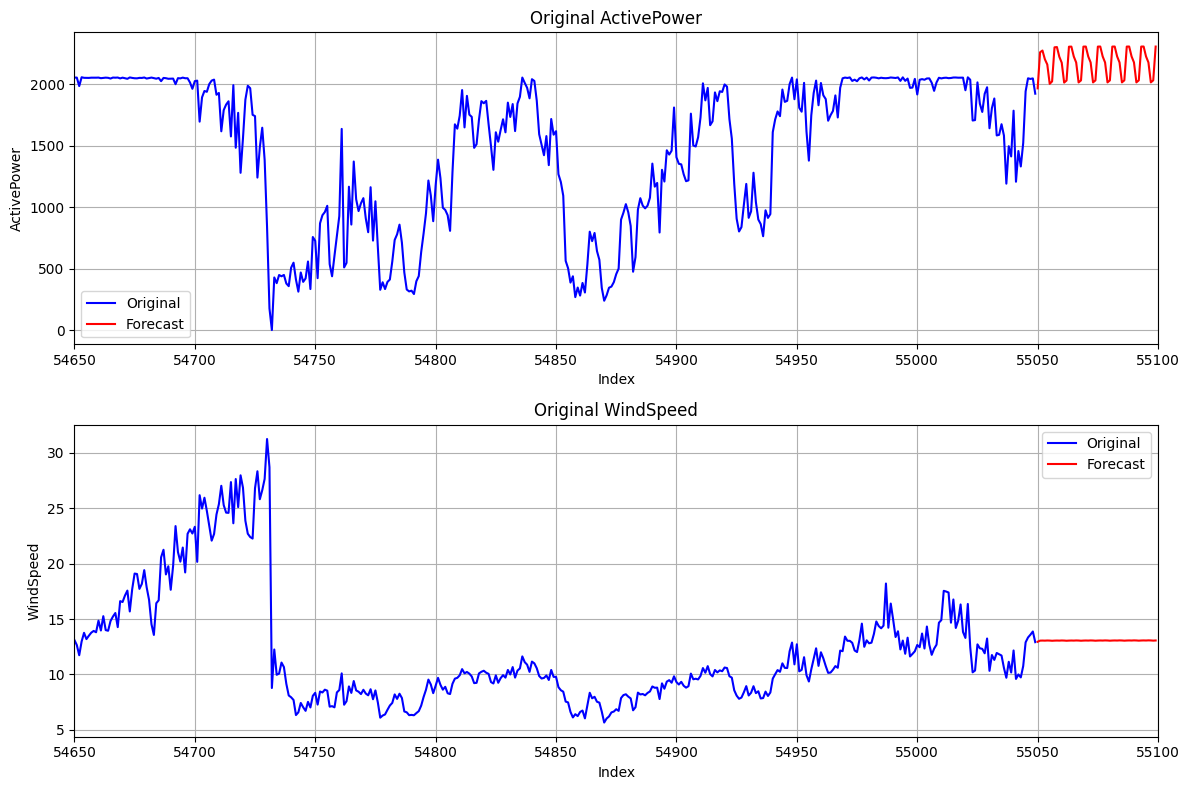

MSR for ActivePower: 175492.2094
MAPE for ActivePower: 0.1998
MSR for WindSpeed: 4.3398
MAPE for WindSpeed: 0.1329
Original File: arganil_turbine_2.txt


MSR for ActivePower: 4007.5059
MAPE for ActivePower: 0.0237
MSR for WindSpeed: 2.1916
MAPE for WindSpeed: 0.0887
Original File: arganil_turbine_3.txt


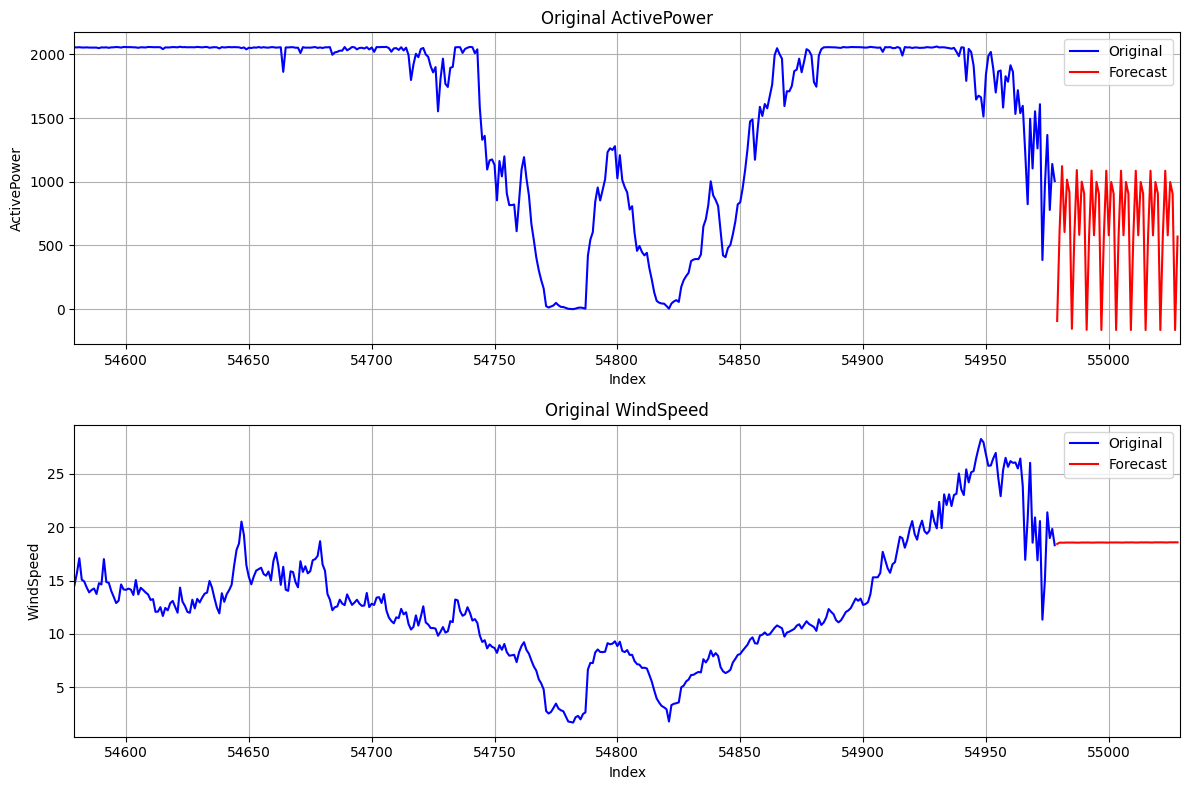

MSR for ActivePower: 1426224.9324
MAPE for ActivePower: 0.6422
MSR for WindSpeed: 33.7051
MAPE for WindSpeed: 0.2165
Original File: arganil_turbine_4.txt


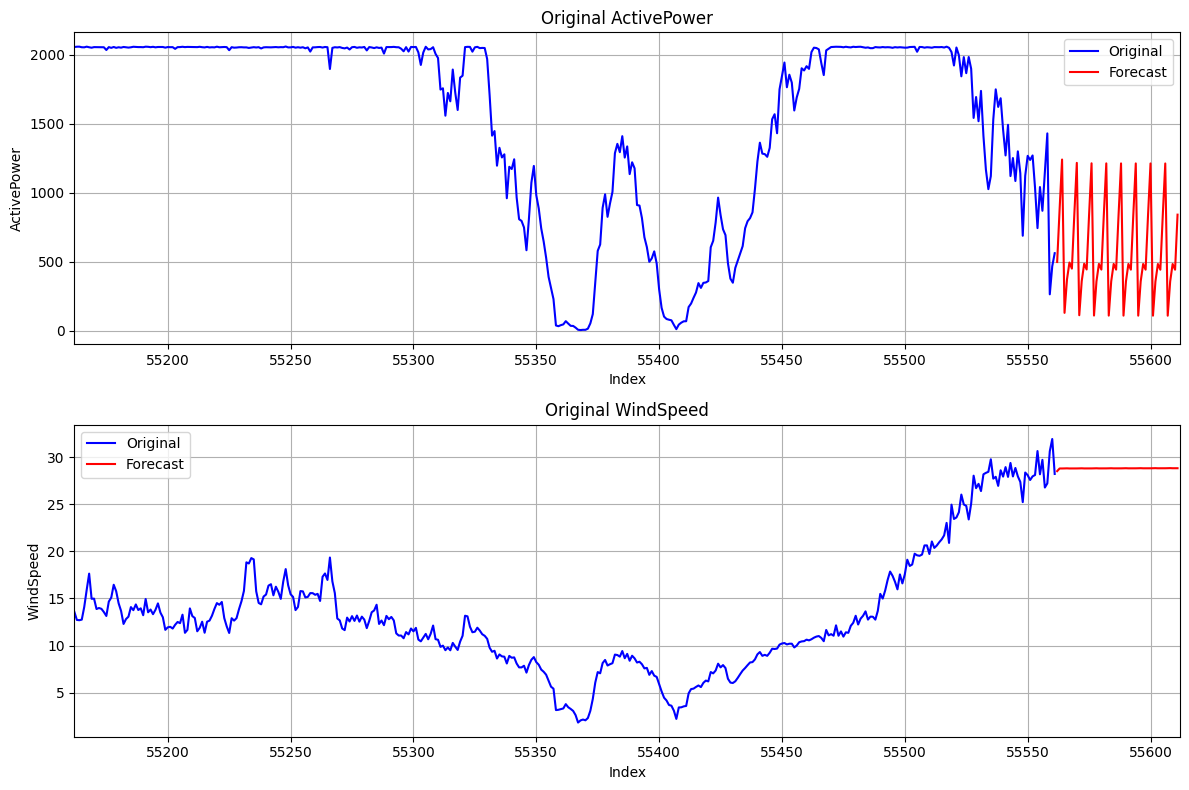

MSR for ActivePower: 1107732.9423
MAPE for ActivePower: 0.5989
MSR for WindSpeed: 12.7732
MAPE for WindSpeed: 0.1097
Original File: arganil_turbine_5.txt


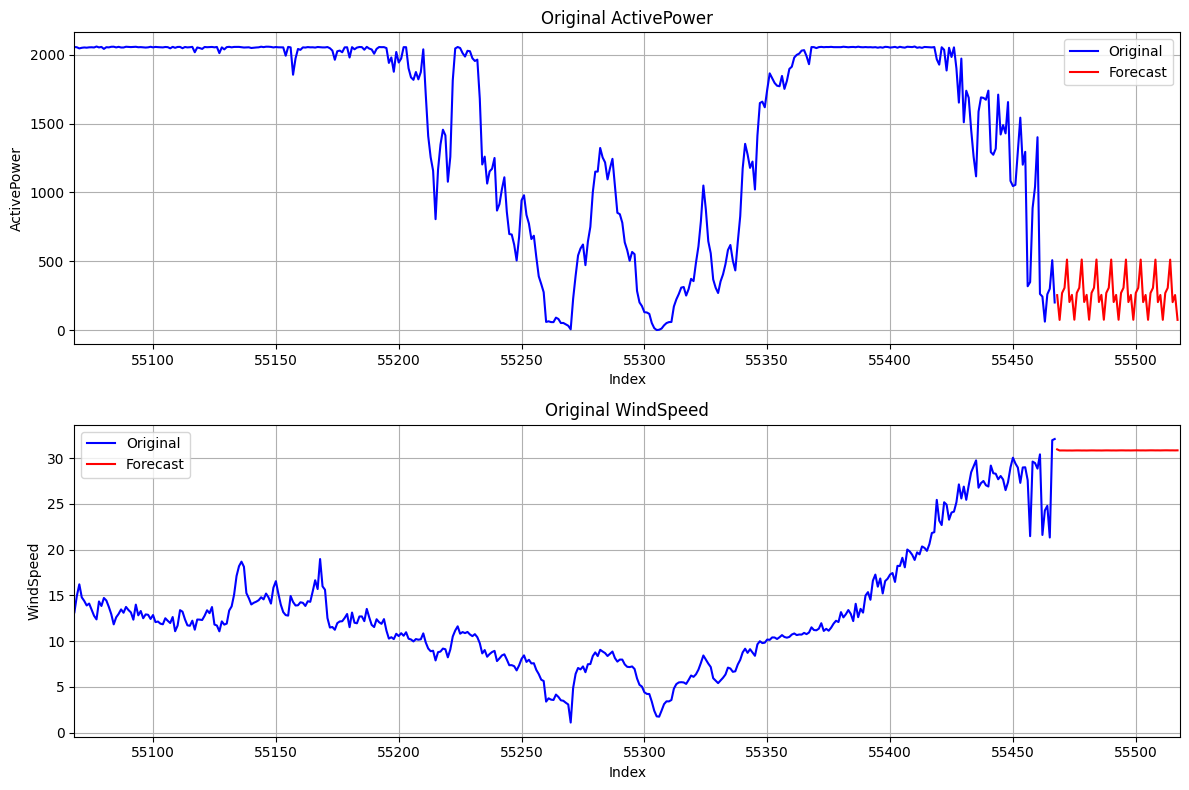

MSR for ActivePower: 1491052.2878
MAPE for ActivePower: 0.8207
MSR for WindSpeed: 22.6347
MAPE for WindSpeed: 0.1621
Original File: arganil_turbine_6.txt


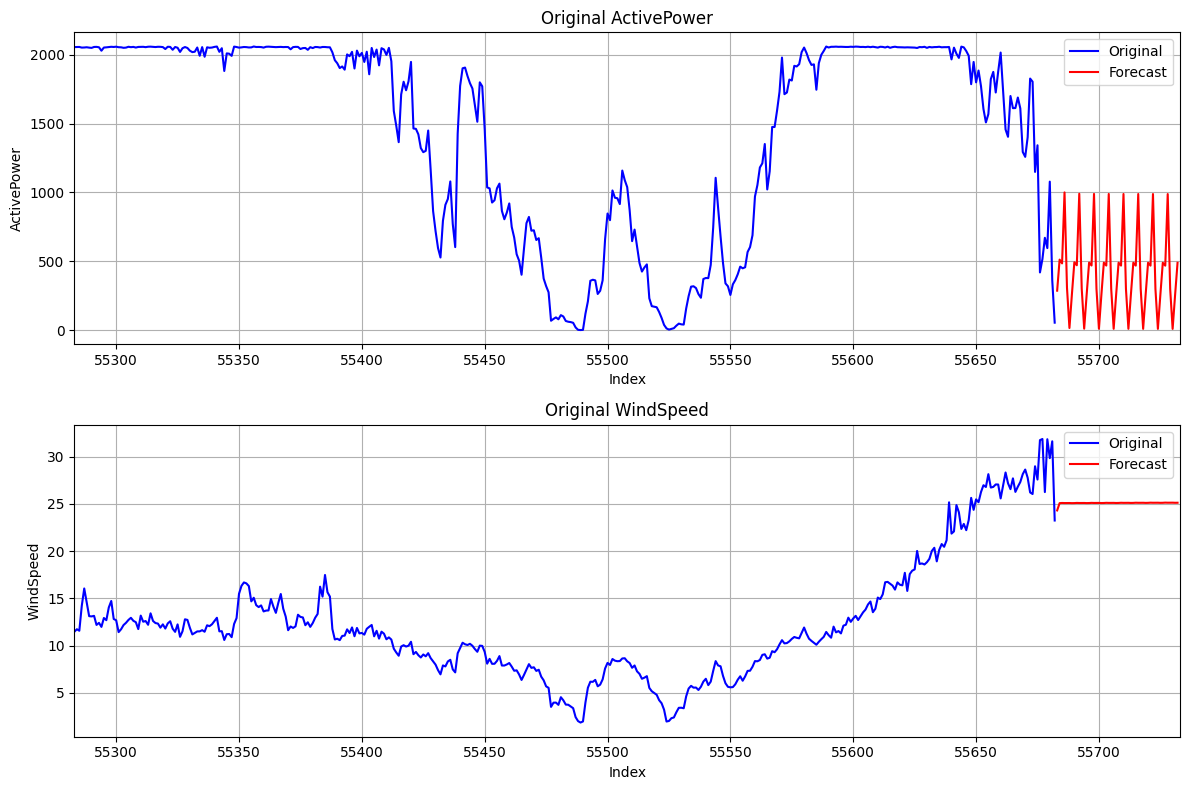

MSR for ActivePower: 1745915.3038
MAPE for ActivePower: 0.8675
MSR for WindSpeed: 10.0098
MAPE for WindSpeed: 0.1026
Original File: arganil_turbine_7.txt


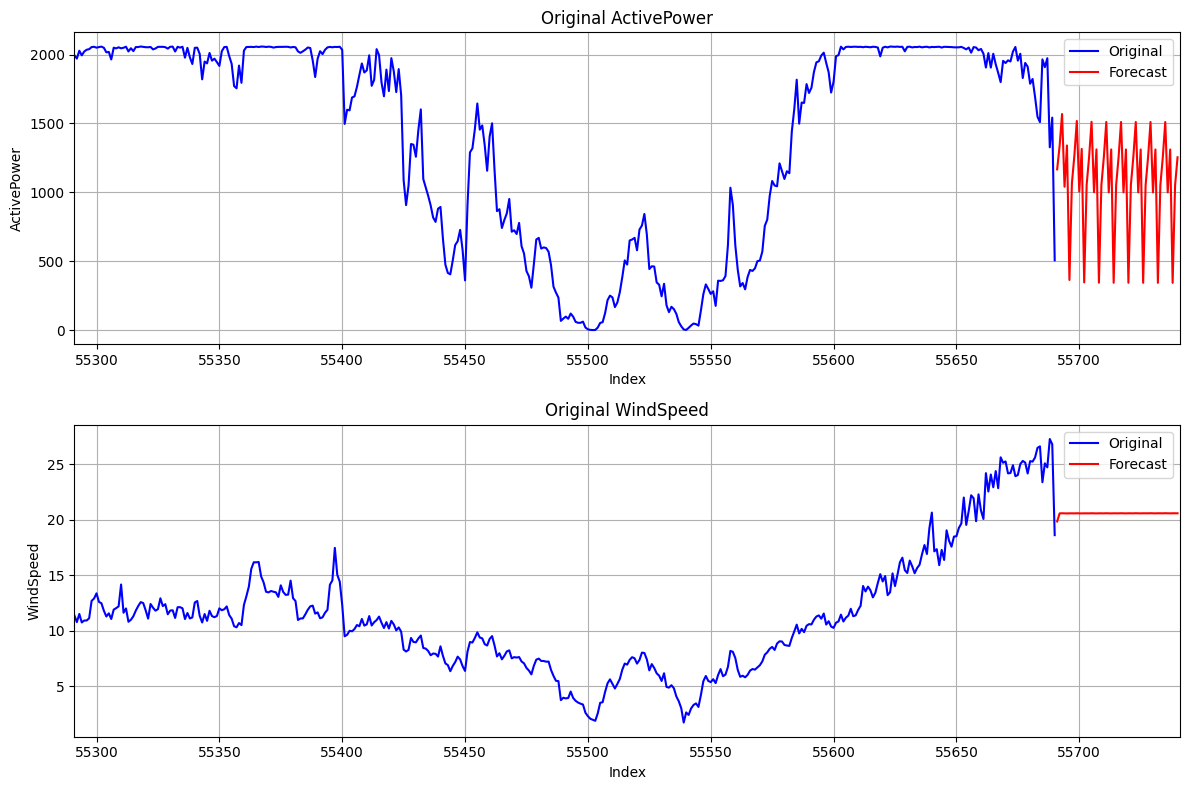

MSR for ActivePower: 854859.0726
MAPE for ActivePower: 0.4603
MSR for WindSpeed: 12.9540
MAPE for WindSpeed: 0.1408
Original File: arganil_turbine_8.txt


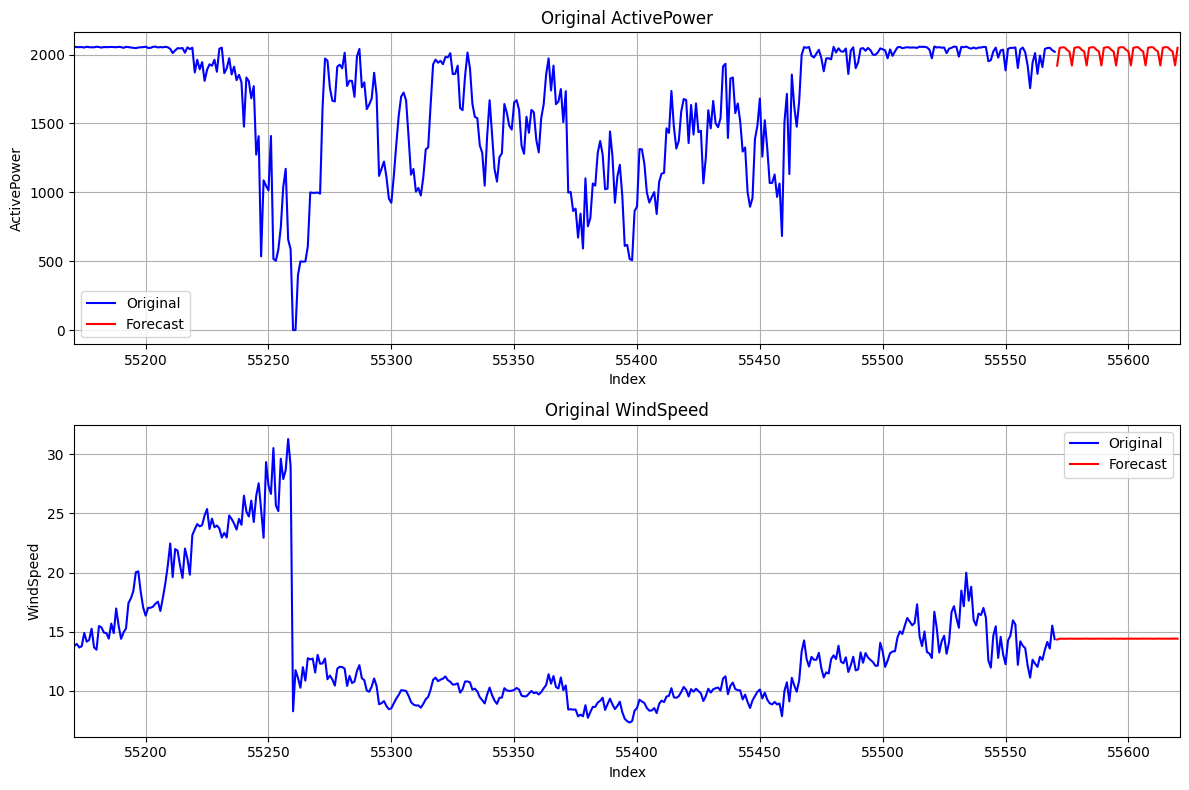

MSR for ActivePower: 6539.3738
MAPE for ActivePower: 0.0269
MSR for WindSpeed: 3.9955
MAPE for WindSpeed: 0.1098
Original File: arganil_turbine_9.txt


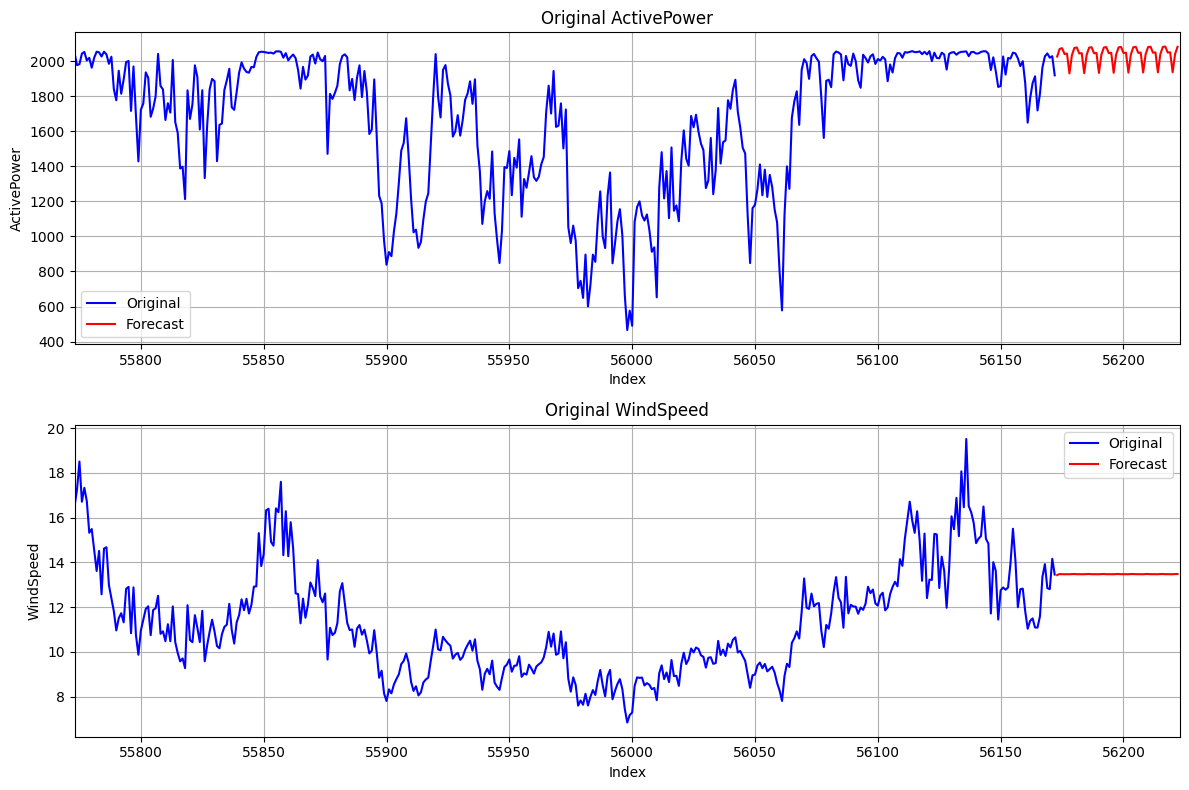

MSR for ActivePower: 14179.6462
MAPE for ActivePower: 0.0384
MSR for WindSpeed: 3.9033
MAPE for WindSpeed: 0.1110


In [32]:

def apply_sarima_forecast(folder_path, num_data_points, num_predictions, seasonality):
    # Iterate over files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            # Print the name of the original file
            print(f"Original File: {file_name}")

            # Load the file
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep='\t')

            # Select the last 400 samples for visualization
            df_visualize = df.iloc[-400:]

            # Create a figure with two subplots for the original data and forecasts
            fig, axs = plt.subplots(2, 1, figsize=(12, 8))

            # Original data plot: ActivePower
            axs[0].plot(df_visualize['ActivePower'], color='blue', label='Original')
            axs[0].set_xlabel('Index')
            axs[0].set_ylabel('ActivePower')
            axs[0].set_title('Original ActivePower')
            axs[0].legend()
            axs[0].grid(True)

            # Original data plot: WindSpeed
            axs[1].plot(df_visualize['WindSpeed'], color='blue', label='Original')
            axs[1].set_xlabel('Index')
            axs[1].set_ylabel('WindSpeed')
            axs[1].set_title('Original WindSpeed')
            axs[1].legend()
            axs[1].grid(True)

            # Perform SARIMA forecasting
            active_power_model = sm.tsa.statespace.SARIMAX(df['ActivePower'], order=(2, 1, 1), seasonal_order=(0, 1, 0, seasonality))
            active_power_results = active_power_model.fit()
            active_power_forecast = active_power_results.get_forecast(steps=num_predictions)

            wind_speed_model = sm.tsa.statespace.SARIMAX(df['WindSpeed'], order=(0, 1, 2), seasonal_order=(0, 1, 1, seasonality))
            wind_speed_results = wind_speed_model.fit()
            wind_speed_forecast = wind_speed_results.get_forecast(steps=num_predictions)

            # Plot the forecasts 
            axs[0].plot(range(len(df), len(df) + num_predictions), active_power_forecast.predicted_mean, color='red', label='Forecast')
            axs[0].set_xlim(len(df) - 400, len(df) + num_predictions)
            axs[0].legend()

            axs[1].plot(range(len(df), len(df) + num_predictions), wind_speed_forecast.predicted_mean, color='red', label='Forecast')
            axs[1].set_xlim(len(df) - 400, len(df) + num_predictions)
            axs[1].legend()

            plt.tight_layout()
            plt.show()

            # Calculate and print MSR and MAPE for both ActivePower and WindSpeed
            active_power_true = df['ActivePower'][-num_predictions:]
            active_power_predicted = active_power_forecast.predicted_mean
            active_power_msr = mean_squared_error(active_power_true, active_power_predicted)
            active_power_mape = mean_absolute_percentage_error(active_power_true, active_power_predicted)

            wind_speed_true = df['WindSpeed'][-num_predictions:]
            wind_speed_predicted = wind_speed_forecast.predicted_mean
            wind_speed_msr = mean_squared_error(wind_speed_true, wind_speed_predicted)
            wind_speed_mape = mean_absolute_percentage_error(wind_speed_true, wind_speed_predicted)

            print(f"MSR for ActivePower: {active_power_msr:.4f}")
            print(f"MAPE for ActivePower: {active_power_mape:.4f}")
            print(f"MSR for WindSpeed: {wind_speed_msr:.4f}")
            print(f"MAPE for WindSpeed: {wind_speed_mape:.4f}")

# Example usage
folder_path = ""
num_data_points = 144  # Number of data points per day
num_predictions = 50  # Number of predictions to be made
seasonality = 6  # Seasonality parameter for SARIMA model

apply_sarima_forecast(folder_path, num_data_points, num_predictions, seasonality)


# Another test

In [5]:
df=df[:20000]

In [9]:

n_forecast = 36
# Split the data into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, shuffle=False)  # Adjust the test_size as needed


In [10]:

# Create SARIMAX models using the training data
train_model = SARIMAX(train_data["WindSpeed"], order=(0, 1, 2), seasonal_order=(0, 1, 1, 6), simple_differencing=False)
train_res = train_model.fit(disp=False)



In [21]:
# Generate predictions for the validation set
# Trim the predicted values to match the length of the validation set

val_forecast = train_res.get_prediction(end=train_model.nobs + n_forecast)
val_predictions = val_forecast.predicted_mean
val_predictions = val_predictions[-len(val_data):]

In [22]:
val_predictions 

12037    10.335783
12038    10.135568
12039    10.107245
12040    10.513998
12041     9.701713
           ...    
16032    15.776136
16033    15.761247
16034    15.759865
16035    15.768624
16036    15.802970
Name: predicted_mean, Length: 4000, dtype: float64

In [23]:

# Calculate evaluation metrics on the validation set
mse = mean_squared_error(val_data['WindSpeed'], val_predictions)
mape = np.mean(np.abs(val_data['WindSpeed'] - val_predictions) / np.abs(val_data['WindSpeed']))
print(f'MSE: {mse}')
print(f'MAPE: {round(mape * 100, 2)}%')


MSE: 44.67440966221565
MAPE: 19.7%


In [19]:
val_data['WindSpeed']

16000    15.82105
16001    16.98158
16002    16.61282
16003    15.19000
16004    14.88500
           ...   
19995    11.86216
19996    12.73077
19997    13.18205
19998    12.87027
19999    13.00833
Name: WindSpeed, Length: 4000, dtype: float64

In [20]:
val_predictions

0         0.000000
1        13.581078
2        12.772969
3        13.694870
4        12.105001
           ...    
16032    15.776136
16033    15.761247
16034    15.759865
16035    15.768624
16036    15.802970
Name: predicted_mean, Length: 16037, dtype: float64